# imports

In [ ]:
# this is for updating libraries below if outdated
# ex. !pip install name_of_package

In [1]:
!pip install torch
# core libraries
import pandas as pd
import numpy as np
import re
import time
import random
import warnings
from collections import Counter

# progress bar 
from tqdm import tqdm

# visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud
import umap.umap_ as umap
import umap.plot
from yellowbrick.cluster import KElbowVisualizer

# Sklearn - Preprocessing 
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    QuantileTransformer,
    OneHotEncoder,
    normalize,
    label_binarize)
from sklearn.feature_selection import VarianceThreshold

#  Sklearn - Model Selection
from sklearn.model_selection import (
    StratifiedKFold,
    RepeatedStratifiedKFold,
    StratifiedGroupKFold,
    GroupShuffleSplit,
    train_test_split,
    cross_val_score)

#  Sklearn - Models 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.mixture import GaussianMixture

# Sklearn - Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    roc_curve,
    auc,
    mean_squared_error,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    silhouette_score,
    davies_bouldin_score,
    normalized_mutual_info_score,
    accuracy_score
)

# Sklearn - Clustering
from sklearn.cluster import (
    KMeans,
    DBSCAN,
    HDBSCAN,
    SpectralClustering,
    AgglomerativeClustering
)


#  PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#  TabNet 
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

#  KAN 
from kan import KAN, MultKAN

#  XGBoost, SHAP 
import xgboost as xgb
import shap

#  Lifelines (Survival Analysis) 
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

#  Scipy 
from scipy import stats
from scipy.stats import entropy, chi2_contingency
from scipy.spatial import distance
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.sparse import csr_matrix

#  Distance Metrics 
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

#  Suppress Warnings 
warnings.filterwarnings("ignore")


Defaulting to user installation because normal site-packages is not writeable
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)


# helper functions

In [2]:
def plot_osa_umap_with_feature_overlay(osa_df, feature_name, title=None, cmap='Reds'):
    """
    Plots UMAP points for OSA patients colored by a feature (e.g., hypertension).
    
    Parameters:
    - osa_df: DataFrame with 'x', 'y' (UMAP), and the feature column
    - feature_name: str, the column to use for coloring
    - title: plot title
    - cmap: colormap for the feature gradient
    """
    feature_values = osa_df[feature_name]
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(osa_df["x"], osa_df["y"], c=feature_values, cmap=cmap, 
                          s=20, alpha=0.8, edgecolor='k', linewidth=0.05)
    
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    cbar = plt.colorbar(scatter)
    cbar.set_label(feature_name.replace('_', ' ').title())
    if title:
        plt.title(title)
    else:
        plt.title(f"UMAP of OSA Patients Colored by {feature_name.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()


In [3]:
def plot_umap_with_custom_colorbar(clusterable_embedding, labels, title="UMAP", point_size=2, point_alpha=0.7):
    """
    Plot UMAP with a custom colorbar in a specific order and lighter shades.

    Parameters:
    - clusterable_embedding: 2D numpy array from UMAP
    - labels: Series of string labels ("OSA Only", "HF Only", etc.)
    - title: Title of the plot
    - point_size, point_alpha: Scatter marker size and transparency
    """
    # Define the final desired label order and their colors
    label_order = ["OSA Only", "OSA & HF", "HF Only"]
    point_colors_map = {
        "OSA Only": "orange",
        "OSA & HF": "red",
        "HF Only": "blue"
    }
    colorbar_colors_map = {
        "OSA Only": "#ffd17e",    # Light orange
        "OSA & HF": "#ff7f7e",    # Light red
        "HF Only": "#7f7fff"      # Light blue
    }

    # Map string labels to integers
    label_to_int = {label: i for i, label in enumerate(label_order)}
    int_labels = labels.map(label_to_int)

    # Create color lists
    scatter_colors = labels.map(point_colors_map)
    colorbar_colors = [colorbar_colors_map[label] for label in label_order]

    # Create colorbar colormap
    cmap = mcolors.ListedColormap(colorbar_colors)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        clusterable_embedding[:, 0],
        clusterable_embedding[:, 1],
        c=int_labels,
        cmap=cmap,
        s=point_size,
        alpha=point_alpha
    )

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(label_order)
    cbar.set_label("Group")

    # Labels
    ax.set_title(title)
    ax.set_xlabel("Embedding-1")
    ax.set_ylabel("Embedding-2")
    ax.set_facecolor("white")
    plt.tight_layout()
    plt.show()


In [4]:
#DR DONG CODE for group split
def repeated_stratified_group_kfold(X, y, groups, n_splits=5, n_repeats=3, random_state=42):
    """
    Generate repeated Stratified Group K-Fold indices.

    Parameters:
        X (array-like): Feature matrix.
        y (array-like): Target labels.
        groups (array-like): Group labels for the samples.
        n_splits (int): Number of folds.
        n_repeats (int): Number of times cross-validator needs to be repeated.
        random_state (int): Random seed for reproducibility.

    Returns:
        List of (train_idx, val_idx) tuples, with total length = n_splits * n_repeats.
    """

    folds = []
    rng = np.random.RandomState(random_state)
    seeds = rng.randint(0, 10000, size=n_repeats)

    for seed in seeds:
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        for train_idx, val_idx in sgkf.split(X, y, groups):
            folds.append((train_idx, val_idx))
    return folds


    # folds = [
    # (train_idx_1, val_idx_1),  # repeat 1, fold 1
    # (train_idx_2, val_idx_2),  # repeat 1, fold 2
    # ...
    # (train_idx_15, val_idx_15)  # repeat 3, fold 5
# ]

# # repeat 1:
# fold 1: train = folds 2,3,4,5 → val = fold 1
# fold 2: train = folds 1,3,4,5 → val = fold 2
# ...
# # repeat 3:
# fold 5: train = folds 1,2,3,4 → val = fold 5

In [5]:
def evaluate_kmeans(data, n_clusters=3, Y = None, random_state=42):
    """
    Perform K-means clustering on the given data and evaluate the clustering.

    Parameters:
    data (array-like): The input data to cluster.
    n_clusters (int): The number of clusters to form.
    Y (array-like): The true labels (optional). Used to calculate Adjusted Rand Index.
    random_state (int): The seed used by the random number generator.

    Returns:
    dict: A dictionary containing evaluation metrics.
    """
    # Fit K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data)
    labels = kmeans.labels_

    # Calculate metrics
    silhouette_avg = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    wcss = kmeans.inertia_

    metrics = {
        'Silhouette Score': silhouette_avg, #--high Measures how similar each point is to its own cluster compared to other clusters.
        'Davies-Bouldin Index': db_index,  #- low Measures the average similarity ratio of each cluster with its most similar cluster.
        'WCSS': wcss                       #- low compactness
    }

    # Calculate ARI if true labels are provided
    if Y is not None:
        ari = adjusted_rand_score(Y, labels)
        metrics['Adjusted Rand Index'] = ari
        print(f'Adjusted Rand Index: {ari}')

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Index: {db_index}')
    print(f'Within-Cluster Sum of Squares (WCSS): {wcss}')

    return metrics

In [6]:


def overlay_osa_on_fused_umap(fused_embedding, hdb_labels, osa_mask, cluster_centers=None):
    """
    Show fused UMAP with HDBSCAN clusters and overlay OSA points in yellow.
    """
    # Define colors
    hdb_colors = {0: "#2ca02c", 1: "#1f77b4", -1: "gray"}  # green, blue, gray for noise

    # Get colors for full dataset
    point_colors = [hdb_colors.get(lbl, 'gray') for lbl in hdb_labels]

    plt.figure(figsize=(10, 7))

    # Plot all fused UMAP with HDBSCAN colors
    plt.scatter(
        fused_embedding[:, 0],
        fused_embedding[:, 1],
        c=point_colors,
        s=10,
        alpha=0.3,
        label='All Admissions'
    )

    # Overlay OSA-only admissions
    plt.scatter(
        fused_embedding[osa_mask, 0],
        fused_embedding[osa_mask, 1],
        color='gold',
        edgecolor='black',
        s=20,
        alpha=0.9,
        label='OSA Admissions'
    )

    # Optional: annotate cluster labels
    for cluster_id in np.unique(hdb_labels):
        if cluster_id == -1:
            continue
        cluster_points = fused_embedding[(hdb_labels == cluster_id)]
        if len(cluster_points) == 0:
            continue
        centroid = cluster_points.mean(axis=0)
        plt.text(
            centroid[0], centroid[1], f"{cluster_id}",
            fontsize=10, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
            ha='center', va='center'
        )

    # Legend
    legend_elements = [
        Patch(facecolor="#2ca02c", label="Cluster 0 (Green)"),
        Patch(facecolor="#1f77b4", label="Cluster 1 (Blue)"),
        Patch(facecolor='gold', edgecolor='black', label="OSA Admissions")
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("OSA Overlay on Fused UMAP")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()


In [7]:
#Capture the 256-dim representation fed into TabNet's final classifier layer.
#- by Dan
def tabnet_encoder_embeddings(model, X_np: np.ndarray, group: int, batch_size: int = 4096) -> np.ndarray:

    encoder_net = model.network
    device = torch.device(model.device_name)
    encoder_net.eval()

    # Locate the final Linear layer whose out_features = n_classes
    final_fc = next(layer for layer in encoder_net.modules()
        if isinstance(layer, nn.Linear) and layer.out_features == group)

    captured = []

    def _grab_input(module, inputs, output):
        captured.append(inputs[0].detach().cpu())   # inp is a tuple [batch_size, 256]

    hook_handle = final_fc.register_forward_hook(_grab_input)

    with torch.no_grad():
        for start in range(0, len(X_np), batch_size):
            batch_np = X_np[start:start + batch_size]
            batch_t = torch.from_numpy(batch_np).to(device) #convert to tensor
            encoder_net(batch_t)                 # hook fires

    hook_handle.remove()
    return torch.cat(captured).numpy()     

In [8]:
def umap_embedding(X, n_neighbors=15, min_dist=0.1, n_components=50, random_state=42, metric = 'euclidean'):
    """
    Perform UMAP embedding on the dataset X with the provided parameters.

    Parameters:
    - X: The feature dataset to be transformed.
    - n_neighbors: The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    - min_dist: The minimum distance between points in the low-dimensional space.
    - n_components: The number of dimensions of the low-dimensional space.
    - random_state: The seed used by the random number generator.

    Returns:
    - clusterable_embedding: The transformed feature dataset.
    - runtime: The time taken to perform the UMAP embedding.
    """
    start_time = time.time()
    clusterable_embedding = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state
    ).fit_transform(X)
    end_time = time.time()

    # Calculate the runtime
    runtime = end_time - start_time
    print(f"UMAP Runtime: {runtime:.6f} seconds")

    return clusterable_embedding, runtime

In [9]:
#util
#- need to adjust based on cohort.
def read_cohort_with_id(cohort_df):
    # cohort_df = pd.read_csv(file).drop(columns = ['Unnamed: 0'], errors='ignore')
    cohort_df['group_name'] = cohort_df['group'].apply(group_str)
    # Group counts
    group_counts = cohort_df['group_name'].value_counts()
    hf_count = group_counts['HF Only']
    osa_count = group_counts['OSA Only']

    # Downsample "HF Only" group
    hf_df = cohort_df[cohort_df['group_name'] == 'HF Only']
    osa_df = cohort_df[cohort_df['group_name'] == 'OSA Only']
    osa_hf_df = cohort_df[cohort_df['group_name'] == 'OSA & HF']

    # Downsample "HF Only" to the same size as "OSA Only"
    hf_df_downsampled = hf_df.sample(n=osa_count, random_state=42)

    # Combine the downsampled "HF Only" group with the other groups
    downsampled_cohort_df = pd.concat([hf_df_downsampled, osa_df, osa_hf_df])

    return downsampled_cohort_df

In [10]:
#- by dan
def split_patients_by_group(X, y, groups, test_size=0.20, valid_size=0.2):
    """Split data by patient groups to prevent data leakage"""
    # first split train+valid vs test
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    trainval_idx, test_idx = next(gss.split(X, y, groups))

    X_trainval, y_trainval, groups_trainval = (X.iloc[trainval_idx], y.iloc[trainval_idx], groups.iloc[trainval_idx])
    X_test, y_test, group_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]

    # second split train vs valid
    gss2 = GroupShuffleSplit(n_splits=1, test_size=valid_size, random_state=42)
    train_idx, valid_idx = next(gss2.split(X_trainval, y_trainval, groups_trainval))

    X_train, y_train = X_trainval.iloc[train_idx], y_trainval.iloc[train_idx]
    X_valid, y_valid = X_trainval.iloc[valid_idx], y_trainval.iloc[valid_idx]

    return X_train, X_valid, X_test, y_train, y_valid, y_test, group_test

In [11]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True  # Make sure CUDA operations are deterministic
    torch.backends.cudnn.benchmark = False  # Disable CUDA's auto-tuner that finds the best algorithm to use for your hardware

In [12]:
#  bin Charlson scores into discrete categories 
def bin_charlson(score):
    if score == 0:
        return "0"
    elif score <= 2:
        return "1–2"
    elif score <= 4:
        return "3–4"
    elif score <= 6:
        return "5–6"
    else:
        return "7+"

In [13]:
#- This do not put different admissions of the same patient in training and testing.
def train_models(cohort_df, report = False):
    # Prepare features and labels
    X = cohort_df.drop(columns=['group_name', 'group', 'hadm_id', 'subject_id'], errors='ignore')
    y = cohort_df['group']
    groups = cohort_df['subject_id']

    models = {
        'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.2, max_iter=5000),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }

    # Use custom repeated StratifiedGroupKFold
    folds = repeated_stratified_group_kfold(X, y, groups, n_splits=5, n_repeats=3, random_state=42)

    results = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name}")
        start_time = time.time()

        # Manually do cross_val_score-like loop
        scores = []
        for train_idx, val_idx in folds:
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            y_true = y.iloc[val_idx]
            y_proba = model.predict_proba(X.iloc[val_idx])
            # print(y_true.shape, np.unique(y_true))
            # print(y_proba.shape, np.unique(y_proba))
            score = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')  # Can use roc_auc_ovr if needed
            scores.append(score)

        end_time = time.time()

        results[model_name] = {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'runtime': end_time - start_time
        }

        print(f'{model_name} - CrossVal: ROC AUC: {results[model_name]["mean_score"]:.3f} (Std: {results[model_name]["std_score"]:.3f})')
        print(f"{model_name} - Runtime: {results[model_name]['runtime']:.6f} seconds")

    # Extra: One pass of RF to inspect predictions
    rf_model = models['Random Forest']
    train_idx, test_idx = folds[0]
    rf_model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_train_preds_rf = rf_model.predict(X.iloc[train_idx])
    y_test_preds_rf = rf_model.predict(X.iloc[test_idx])

    lr_model = models['Logistic Regression']
    train_idx, test_idx = folds[0]
    lr_model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_train_preds_lr = lr_model.predict(X.iloc[train_idx])
    y_test_preds_lr = lr_model.predict(X.iloc[test_idx])

    if report:
        print("\nRandom Forest - Training Results")
        print(classification_report(y.iloc[train_idx], y_train_preds_rf))
        print(confusion_matrix(y.iloc[train_idx], y_train_preds_rf))

        print("Random Forest - Testing Results")
        print(classification_report(y.iloc[test_idx], y_test_preds_rf))
        print(confusion_matrix(y.iloc[test_idx], y_test_preds_rf))


        print("Logistic Regression - Training Results")
        print(classification_report(y.iloc[train_idx], y_train_preds_lr))
        print(confusion_matrix(y.iloc[train_idx], y_train_preds_lr))

        print("Logistic Regression - Testing Results")
        print(classification_report(y.iloc[test_idx], y_test_preds_lr))
        print(confusion_matrix(y.iloc[test_idx], y_test_preds_lr))

    return results, rf_model, lr_model

In [14]:
def plot_umap_embedding(clusterable_embedding, labels, group, colors=None, n_clusters=None, title='UMAP Embedding', xlabel='Embedding-1', ylabel='Embedding-2', background_color='white', point_size=0.1, point_alpha=0.5):
    """
    Creates a scatter plot of UMAP embeddings.

    Parameters:
    - clusterable_embedding: The transformed feature dataset.
    - labels: The cluster labels for each data point.
    - group: The unique number for each group.
    - colors: A list of colors to use for the clusters.
    - n_clusters: The number of clusters.
    - title: The title of the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - background_color: The background color of the plot.
    - point_size: The size of the points in the scatter plot.
    - point_alpha: The alpha transparency for the points.
    """
    if colors is None:
        colors = ['orange', 'green', 'blue']  # Default colors if none provided
    if n_clusters is None:
        n_clusters = len(group)

    cmap = mcolors.ListedColormap(colors[:n_clusters])

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_facecolor(background_color)

    sc = plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=labels, s=point_size, alpha=point_alpha, cmap=cmap)

    labels_group_str = labels.apply(group_str)

    cbar = fig.colorbar(sc)
    cbar.set_ticks(group)
    cbar.set_ticklabels(labels_group_str.unique())

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [15]:
def plot_binary_feature_overlay_umap(embedding, feature_values, feature_name):
    """
    Overlay binary feature (presence/absence) on UMAP.
    Red = present, Grey = absent.
    """
    colors = np.where(feature_values > 0, "#d62728", "#d3d3d3")  # red if present, light grey if absent

    plt.figure(figsize=(10, 7))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=colors,
        s=8,
        alpha=0.9
    )
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#d62728", label="Present"),
        Patch(facecolor="#d3d3d3", label="Absent")
    ]
    plt.legend(handles=legend_elements, title=feature_name, loc='upper right')
    plt.title(f"UMAP – Binary Overlay: {feature_name}", fontsize=16, fontweight='bold')
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()


In [16]:
def plot_star_umap_binary(df, title="UMAP: Essential (Primary) Hypertension by Cluster"):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define binary colors: 0 = grey, 1 = orange (colorblind version)
    colors = {0: "#999999", 1: "#E69F00"}  # greys and orange 
    df["color"] = df["hypertension"].map(colors)

    # Plot all points
    ax.scatter(
        df["x"], df["y"],
        c=df["color"],
        s=20,
        alpha=0.85,
        edgecolor='k', linewidth=0.05
    )

    # Annotate clusters with % hypertension
    for cluster_id in sorted(df["cluster"].unique()):
        cluster_data = df[df["cluster"] == cluster_id]
        x_center = cluster_data["x"].median()
        y_center = cluster_data["y"].median()
        percent = 100 * cluster_data["hypertension"].mean()
        label = f"{percent:.1f}% HTN"

        ax.text(
            x_center, y_center, label,
            fontsize=10, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
        )

    # legend
    patch_0 = mpatches.Patch(color=colors[0], label='No Hypertension')
    patch_1 = mpatches.Patch(color=colors[1], label='Hypertension')
    ax.legend(handles=[patch_0, patch_1], title="Essential Hypertension")

    ax.set_title(title)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
def plot_umaps_side_by_side(umap_structured, umap_unstructured, labels, group, title1='Structured UMAP', title2='Unstructured UMAP',colors=None, background_color='white', point_size=0.1, point_alpha=0.5,xlabel='Embedding-1', ylabel='Embedding-2'):
    """
    Plots side-by-side UMAP visualizations for structured and unstructured embeddings.

    Parameters
    ----------
    umap_structured : array-like, shape (n_samples, 2)
        2D UMAP coordinates for structured data.
    umap_unstructured : array-like, shape (n_samples, 2)
        2D UMAP coordinates for unstructured data.
    labels : array-like or pandas.Series
        Cluster or group labels for each sample.
    group : list or array
        Unique group identifiers in the dataset (used for colorbar ticks).
    title1 : str, optional
        Title for the structured UMAP plot.
    title2 : str, optional
        Title for the unstructured UMAP plot.
    colors : list, optional
        List of colors for groups. Defaults to ['orange', 'green', 'blue'].
    background_color : str, optional
        Background color for the plots.
    point_size : float, optional
        Marker size for scatter points.
    point_alpha : float, optional
        Transparency level for scatter points.
    xlabel : str, optional
        Label for the x-axis.
    ylabel : str, optional
        Label for the y-axis.

    Returns
    -------
    None
        Displays the side-by-side UMAP scatter plots with a shared colorbar.
    """
    if colors is None:
        colors = ['orange', 'green', 'blue'] # default colors for group labels

    n_clusters = len(group)
    cmap = mcolors.ListedColormap(colors[:n_clusters])

    fig, axs = plt.subplots(1, 3, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1, 0.05]})
    
    for ax in axs[:2]:
        ax.set_facecolor(background_color)
        ax.grid(True)  # <-- Keep the grid
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    label_array = np.array(labels)

    # structured UMAP
    sc1 = axs[0].scatter(umap_structured[:, 0], umap_structured[:, 1],
                         c=label_array, cmap=cmap, s=point_size, alpha=point_alpha)
    axs[0].set_title(title1)

    # unstructured UMAP
    sc2 = axs[1].scatter(umap_unstructured[:, 0], umap_unstructured[:, 1],
                         c=label_array, cmap=cmap, s=point_size, alpha=point_alpha)
    axs[1].set_title(title2)

    # shared colorbar
    sm = ScalarMappable(cmap=cmap)
    cbar = fig.colorbar(sm, cax=axs[2], ticks=group)
    
    if isinstance(labels, pd.Series):
        label_strs = labels.apply(group_str).unique()
        cbar.set_ticklabels(label_strs)
    else:
        cbar.set_ticklabels([str(g) for g in group])

    cbar.set_label("Group")
    plt.tight_layout()
    plt.show()


In [18]:


def plot_loss(loss_hist):
    plt.plot(loss_hist, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Contrastive Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
def plot_combined_umap_panels(clusterable_embedding_fused, y_true_labels, X_test,title="UMAP Summary – Group | HDBSCAN | Hypertension"):

    df = pd.DataFrame(clusterable_embedding_fused, columns=["x", "y"]).reset_index(drop=True)
    df["group"] = pd.Series(y_true_labels).reset_index(drop=True)
    df["hypertension"] = X_test.reset_index(drop=True)["Essential (primary) hypertension"]

    # Group labels 
    group_colors = ['orange', 'red', 'blue']
    group_cmap = mcolors.ListedColormap(group_colors)
    group_norm = mcolors.BoundaryNorm(boundaries=np.arange(4)-0.5, ncolors=3)

    # HDBSCAN
    hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5, prediction_data=True)
    df["hdb_cluster"] = hdb.fit_predict(clusterable_embedding_fused)

    # Assign distinct colors for HDBSCAN (colorblind friendly)
    unique_hdb = np.unique(df["hdb_cluster"])
    palette = sns.color_palette("colorblind", len(unique_hdb))
    hdb_color_map = {label: palette[i] if label != -1 else "#999999" for i, label in enumerate(unique_hdb)}
    df["hdb_color"] = df["hdb_cluster"].map(hdb_color_map)

    # KMeans (with cluster % hypertension)
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
    df["kmeans_cluster"] = kmeans.fit_predict(clusterable_embedding_fused)
    df["kmeans_color"] = df["hypertension"].map({0: "#999999", 1: "#E69F00"})

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    scatter1 = axs[0].scatter(df["x"], df["y"], c=df["group"], cmap=group_cmap, norm=group_norm,
                              s=20, alpha=0.85, edgecolor='k', linewidth=0.05)
    axs[0].set_title("A. Group Labels")
    axs[0].set_xlabel("UMAP-1")
    axs[0].set_ylabel("UMAP-2")
    axs[0].grid(True)
    cbar1 = fig.colorbar(ScalarMappable(cmap=group_cmap, norm=group_norm), ax=axs[0])
    cbar1.set_label("Group")
    cbar1.set_ticks([0, 1, 2])
    cbar1.set_ticklabels(["OSA", "OSA + HF", "HF"])

    # --- HDBSCAN 
    axs[1].scatter(df["x"], df["y"], c=df["hdb_color"],
                   s=20, alpha=0.85, edgecolor='k', linewidth=0.05)
    axs[1].set_title("B. HDBSCAN Clusters")
    axs[1].set_xlabel("UMAP-1")
    axs[1].set_ylabel("UMAP-2")
    axs[1].grid(True)

    # Create legend 
    legend_handles = [mpatches.Patch(color=hdb_color_map[label], label=f"Cluster {label}" if label != -1 else "Noise")
                      for label in unique_hdb]
    axs[1].legend(handles=legend_handles, title="HDBSCAN Cluster", loc='best', fontsize=9)

    # - Hypertension in KMeans Clusters 
    axs[2].scatter(df["x"], df["y"], c=df["kmeans_color"],
                   s=20, alpha=0.85, edgecolor='k', linewidth=0.05)
    axs[2].set_title("C. Essential Hypertension by KMeans Cluster")
    axs[2].set_xlabel("UMAP-1")
    axs[2].set_ylabel("UMAP-2")
    axs[2].grid(True)

    # annotate each KMeans cluster with hypertension %
    for cluster_id in sorted(df["kmeans_cluster"].unique()):
        cluster_data = df[df["kmeans_cluster"] == cluster_id]
        x_center = cluster_data["x"].median()
        y_center = cluster_data["y"].median()
        percent = 100 * cluster_data["hypertension"].mean()
        label = f"{percent:.1f}% HTN"
        axs[2].text(
            x_center, y_center, label,
            fontsize=10, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    # legend for binary hypertension
    patch_0 = mpatches.Patch(color="#999999", label='No Hypertension')
    patch_1 = mpatches.Patch(color="#E69F00", label='Has Hypertension')
    axs[2].legend(handles=[patch_0, patch_1], title="Hypertension Status")

    fig.suptitle(title, fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()


In [20]:
def umap_embedding(X, n_neighbors=15, min_dist=0.1, n_components=50, random_state=42, metric = 'euclidean'):
    """
    Perform UMAP embedding on the dataset X with the provided parameters.

    Parameters:
    - X: The feature dataset to be transformed.
    - n_neighbors: The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    - min_dist: The minimum distance between points in the low-dimensional space.
    - n_components: The number of dimensions of the low-dimensional space.
    - random_state: The seed used by the random number generator.

    Returns:
    - clusterable_embedding: The transformed feature dataset.
    - runtime: The time taken to perform the UMAP embedding.
    """
    start_time = time.time()
    clusterable_embedding = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state
    ).fit_transform(X)
    end_time = time.time()

    # Calculate the runtime
    runtime = end_time - start_time
    print(f"UMAP Runtime: {runtime:.6f} seconds")

    return clusterable_embedding, runtime

In [21]:
#- simulate this: X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 42)
def train_test_split_customized(cohort_df, keep_id_flag = False, num_splits = 5):
    # Prepare features and labels
    if keep_id_flag:
        X = cohort_df
    else:
        X = cohort_df.drop(columns=['group_name', 'group', 'hadm_id', 'subject_id'], errors='ignore')
    y = cohort_df['group']
    groups = cohort_df['subject_id']

    # Use custom repeated StratifiedGroupKFold
    folds = repeated_stratified_group_kfold(X, y, groups, n_splits=num_splits, n_repeats=3, random_state=42)
    train_idx, test_idx = folds[0]
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    return X_train, X_test, y_train, y_test

In [22]:
#- need to adjust based on cohort.
def read_cohort_with_id(cohort_df):
    # cohort_df = pd.read_csv(file).drop(columns = ['Unnamed: 0'], errors='ignore')
    cohort_df['group_name'] = cohort_df['group'].apply(group_str)
    # Group counts
    group_counts = cohort_df['group_name'].value_counts()
    hf_count = group_counts['HF Only']
    osa_count = group_counts['OSA Only']

    # Downsample "HF Only" group
    hf_df = cohort_df[cohort_df['group_name'] == 'HF Only']
    osa_df = cohort_df[cohort_df['group_name'] == 'OSA Only']
    osa_hf_df = cohort_df[cohort_df['group_name'] == 'OSA & HF']

    # Downsample "HF Only" to the same size as "OSA Only"
    hf_df_downsampled = hf_df.sample(n=osa_count, random_state=42)

    # Combine the downsampled "HF Only" group with the other groups
    downsampled_cohort_df = pd.concat([hf_df_downsampled, osa_df, osa_hf_df])

    return downsampled_cohort_df

In [23]:
#dist of patients
def get_group_distribution(df, group_col='group'):
    """
    Returns a DataFrame showing, for each unique value in `group_col`,
    the raw count and its percentage of the total.
    """
    counts = df[group_col].value_counts().sort_index()
    percents = (counts / counts.sum() * 100).round(2)
    return pd.DataFrame({
        'count': counts,
        'percent': percents
    })

# Example usage:
# osa_hf_all_features = pd.read_csv(root_path_dong + 'data/osa_hf_all_features_labeled_processed.csv') \
#                         .drop(columns=['Unnamed: 0','text','osa','hf'], errors='ignore')
# downsampled_cohort_df = read_cohort_with_id(osa_hf_all_features)


In [24]:
#- can use group instead.
def group_str(group_int):
    if group_int == 0:
        return 'OSA Only'
    elif group_int == 1:
        return 'OSA & HF'
    else:
        return 'HF Only'

# load and prepare data

In [25]:
root_path_dong = '/global/cfs/cdirs/m1532/Projects_MVP/adong/2025/'

In [26]:
set_seed(42)

In [27]:
osa_hf_all_features_labeled_processed = pd.read_csv(root_path_dong + 'data/osa_hf_all_features_labeled_processed.csv').drop(columns = ['Unnamed: 0', 'text', 'osa', 'hf'], errors = 'ignore')
#osa_hf_all_features_labeled_processed = osa_hf_all_features_labeled_processed_reduced_shap_keys_xgb (un comment as needed)

downsampled_cohort_df = read_cohort_with_id(osa_hf_all_features_labeled_processed)

X = downsampled_cohort_df.drop(columns=['group_name', 'group', 'hadm_id', 'subject_id'], errors='ignore')
y = downsampled_cohort_df['group']
groups = downsampled_cohort_df['subject_id']
X_train, X_val, X_test, y_train, y_val, y_test, test_group = split_patients_by_group(X, y, groups, test_size=0.20, valid_size=0.2)

# convert to numpy arrays before feeding into model
X_train_np = X_train.to_numpy().astype(np.float32)
X_test_np = X_test.to_numpy().astype(np.float32)
X_val_np = X_val.to_numpy().astype(np.float32)
X_np = X.to_numpy().astype(np.float32)

y_train_np = y_train.to_numpy().astype(np.float32)
y_test_np = y_test.to_numpy().astype(np.float32)
y_val_np = y_val.to_numpy().astype(np.float32)

In [28]:
# verify distribution of patients
dist_df = get_group_distribution(downsampled_cohort_df, group_col='group')
print(dist_df)

       count  percent
group                
0      14322    42.15
1       5333    15.70
2      14322    42.15


In [29]:
# train / test / validation shapes from above
print(X_train_np.shape)
print(X_test_np.shape)
print(X_val_np.shape)

(21674, 1340)
(6872, 1340)
(5431, 1340)


In [30]:
# total cohort shape
downsampled_cohort_df.shape

(33977, 1344)

# define and train tabnet model

epoch 0  | loss: 1.37834 | valid_accuracy: 0.42865 | valid_logloss: 1.04045 |  0:00:12s
epoch 1  | loss: 0.91799 | valid_accuracy: 0.61941 | valid_logloss: 0.91414 |  0:00:22s
epoch 2  | loss: 0.82807 | valid_accuracy: 0.64298 | valid_logloss: 0.85328 |  0:00:32s
epoch 3  | loss: 0.8032  | valid_accuracy: 0.68054 | valid_logloss: 0.75626 |  0:00:42s
epoch 4  | loss: 0.70588 | valid_accuracy: 0.73964 | valid_logloss: 0.61589 |  0:00:52s
epoch 5  | loss: 0.6141  | valid_accuracy: 0.76745 | valid_logloss: 0.57043 |  0:01:03s
epoch 6  | loss: 0.56116 | valid_accuracy: 0.77776 | valid_logloss: 0.54884 |  0:01:13s
epoch 7  | loss: 0.51451 | valid_accuracy: 0.77444 | valid_logloss: 0.57294 |  0:01:23s
epoch 8  | loss: 0.46606 | valid_accuracy: 0.7656  | valid_logloss: 0.61916 |  0:01:33s
epoch 9  | loss: 0.4149  | valid_accuracy: 0.75677 | valid_logloss: 0.62931 |  0:01:43s
Stop training because you reached max_epochs = 10 with best_epoch = 6 and best_valid_logloss = 0.54884


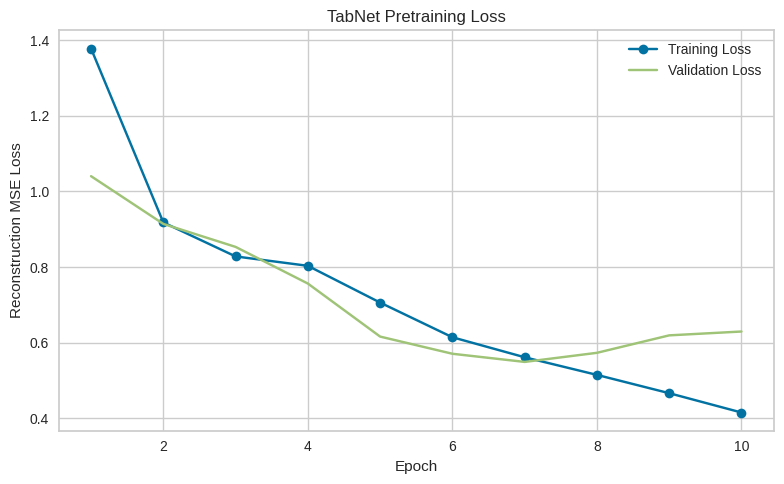

In [31]:
'''
 Grid-searched hyperparameters are already applied here:
 
n_d, n_a: dimensions of the decision & attention steps
n_steps: number of sequential decision steps
gamma: relaxation parameter controlling feature reuse
lambda_sparse: sparsity regularization
n_independent, n_shared: define feature transformer structure
optimizer: Adam with custom LR + weight decay
scheduler: step decay for learning rate
mask_type: entmax (sparser than softmax, helps with feature selection)
'''
set_seed(42)

tabnet_model = TabNetClassifier(
    n_d=128, n_a=128, n_steps=5, gamma=1.3,
    lambda_sparse=1e-3, n_independent=2, n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2, weight_decay=1e-5),
    mask_type="entmax",
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=50, gamma=0.9),
    verbose=1,
    device_name="cpu")

tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['valid'], eval_metric=['accuracy', 'logloss'],
    max_epochs=10, patience=20,
    batch_size=256, virtual_batch_size=128,
    drop_last=False)

# collect training/validation losses for later plotting/diagnostics
train_losses = tabnet_model.history['loss']
val_losses = tabnet_model.history['valid_logloss']


# After training, get dense representations from TabNet encoder these embeddings will be used for downstream tasks
embeddings_X_test = tabnet_encoder_embeddings(tabnet_model, X_test_np, y.nunique())


# plots to view training results
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction MSE Loss')
plt.title('TabNet Pretraining Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# verify shape of emebddings
embeddings_X_test.shape

(6872, 128)

In [33]:
# convert embeddings into a dataframe to perform operations on
X_test_df = pd.DataFrame(embeddings_X_test).reset_index(drop = True)
y_df = pd.DataFrame(y_test, columns = ['group']).reset_index(drop = True)
group_df = pd.DataFrame(test_group, columns = ['subject_id']).reset_index(drop = True)
X_test_all_df = pd.concat([X_test_df, y_df, group_df], axis = 1).fillna(0)


Training Logistic Regression
Logistic Regression - CrossVal: ROC AUC: 0.887 (Std: 0.010)
Logistic Regression - Runtime: 2.667537 seconds

Training Random Forest
Random Forest - CrossVal: ROC AUC: 0.872 (Std: 0.011)
Random Forest - Runtime: 33.470816 seconds


({'Logistic Regression': {'mean_score': 0.8867265169895985,
   'std_score': 0.00986090905459858,
   'runtime': 2.667537212371826},
  'Random Forest': {'mean_score': 0.8723967864102671,
   'std_score': 0.011102372338212398,
   'runtime': 33.470815896987915}},
 RandomForestClassifier(),
 LogisticRegression(C=0.2, max_iter=5000, multi_class='multinomial'))

## plot structured embeddings (UMAP)

UMAP Runtime: 26.248497 seconds
Adjusted Rand Index: 0.27823954295817205
Silhouette Score: 0.3818184435367584
Davies-Bouldin Index: 0.9337035801485066
Within-Cluster Sum of Squares (WCSS): 60797.171875


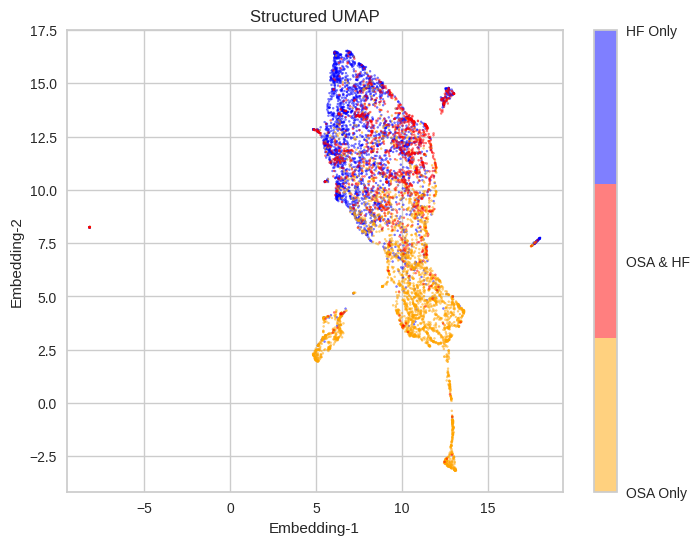

In [34]:
# cluster structured embeddings via UMAP and colllect metrics TRAIN ON GPU TO GET BETTER RESULT (this is trained on cpu for testing only)
latent_representations_ae = embeddings_X_test
clusterable_embedding_ae, runtime = umap_embedding(latent_representations_ae, n_components=2,n_neighbors=50, min_dist=0.1)
evaluate_kmeans(clusterable_embedding_ae, Y = y_test,  n_clusters=3)
group = list(y.unique())
plot_umap_embedding(clusterable_embedding_ae, y_test, group, colors=['orange', 'red', 'blue'], point_size=2, title = "Structured UMAP")

## feature importance plots from TabNet

In [39]:
#get global importance from the tabnet model output


#  get the explanation output from TabNet
explanation_output = tabnet_model.explain(X_train_np)

#  unpack the output tuple of masks
if isinstance(explanation_output, tuple):
    M_explain, _ = explanation_output  # (num_samples, num_features)
else:
    M_explain = explanation_output

#  Compute average importance across all samples
global_feature_importance = M_explain.mean(axis=0)
print("Computed global importance shape:", global_feature_importance.shape)

#  sort and get top features
feature_names = X.columns.tolist()

sorted_indices = np.argsort(global_feature_importance)[::-1]

all_feature_importance_count_dict  = {}
for f in range(len(feature_names)):
    all_feature_importance_count_dict[feature_names[sorted_indices[f]]] = global_feature_importance[sorted_indices[f]]
            # print(f, feature_labels[sorted_indices[f]])

for label, value in all_feature_importance_count_dict.items():
    print(f"{label}: {value}")

Computed global importance shape: (1340,)
Essential (primary) hypertension: 5.214827245797388
charlson: 3.7269570087190536
bmi: 2.87780521052383
Disorders of phosphorus metabolism: 2.8278500612434625
age: 2.118240711094786
Urea Nitrogen: 1.95333944791777
Hypertensive chronic kidney disease with stage 1 through stage 4 chronic kidney disease, or unspecified chronic kidney disease: 1.6454539393335015
Mitral valve disorders: 1.2354198421659452
Hypertensive chronic kidney disease with stage 5 chronic kidney disease or end stage renal disease: 0.6453298930730986
Pravastatin: 0.6016495306266804
Chronic kidney disease, stage 2 (mild): 0.5611358934425827
Abnormal coagulation profile_79092: 0.47794569845755236
Furosemide: 0.453161203816674
Hypoxemia_79902: 0.2545450316891387
Obesity hypoventilation syndrome: 0.2542216486789111
Aluminum-Magnesium Hydrox.-Simethicone: 0.19786028247716697
PT: 0.1485406350630862
Unspecified place or not applicable: 0.1358029013292056
Unspecified urinary incontinenc

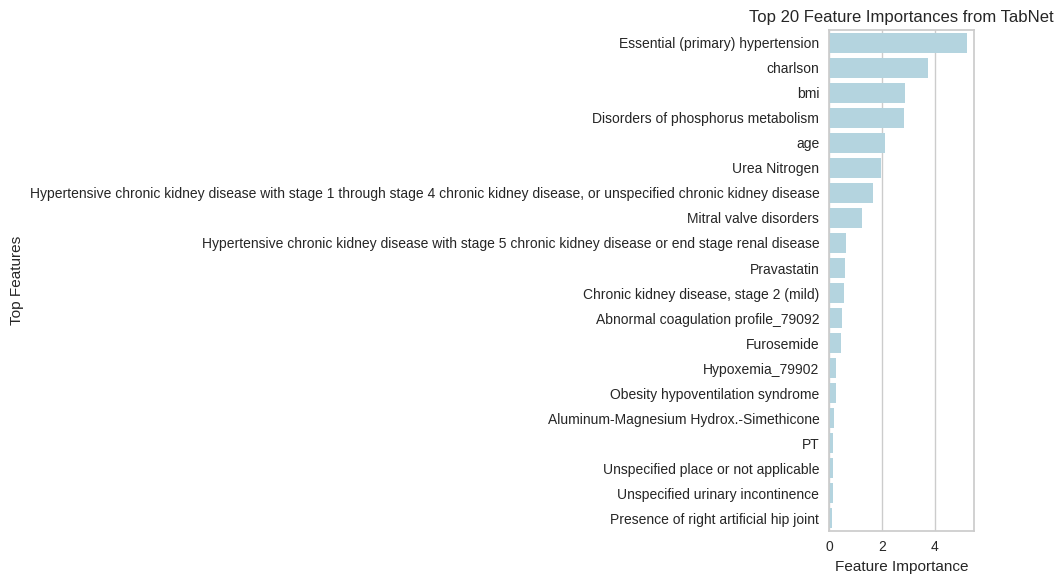

In [40]:
# make chart for top important features from the model output
top_n = 20
top_feature_names = [feature_names[i] for i in sorted_indices[:top_n]]
top_importance_scores = [global_feature_importance[i] for i in sorted_indices[:top_n]]

# Plotting top 20 with light blue bars
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importance_scores, y=top_feature_names, color='#add8e6') 
plt.xlabel("Feature Importance")
plt.ylabel("Top Features")
plt.title(f"Top {top_n} Feature Importances from TabNet")
plt.tight_layout()
plt.show()


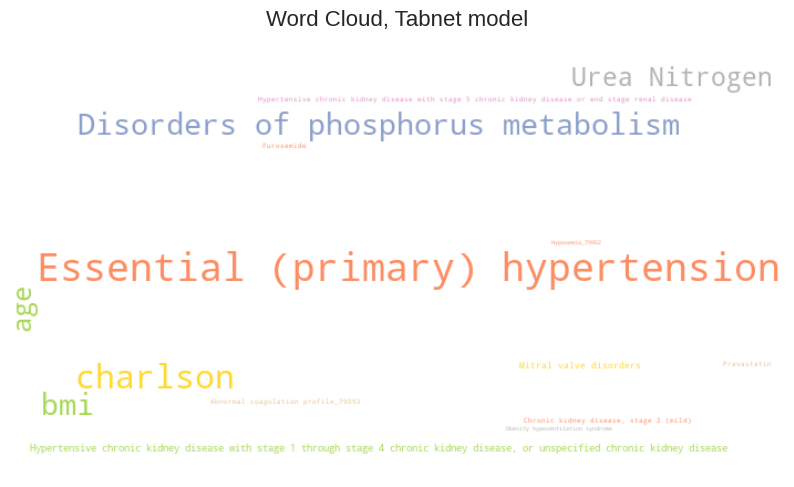

In [41]:
# Generate the word cloud with text size based on cosine distances
wordcloud = WordCloud(width=700, height=400, background_color='white', min_font_size=5, max_font_size=50, colormap='Set2', max_words = 50).generate_from_frequencies(all_feature_importance_count_dict)

# plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud, Tabnet model", fontsize=16)
plt.show()

## structured emebddings classification (RF, LR, KAN)

In [36]:
# RF, LR classification report
train_models(X_test_all_df)


Training Logistic Regression
Logistic Regression - CrossVal: ROC AUC: 0.887 (Std: 0.010)
Logistic Regression - Runtime: 2.521970 seconds

Training Random Forest
Random Forest - CrossVal: ROC AUC: 0.873 (Std: 0.010)
Random Forest - Runtime: 33.397889 seconds


({'Logistic Regression': {'mean_score': 0.8867265169895985,
   'std_score': 0.00986090905459858,
   'runtime': 2.5219695568084717},
  'Random Forest': {'mean_score': 0.8726798881003737,
   'std_score': 0.010291099059965643,
   'runtime': 33.39788889884949}},
 RandomForestClassifier(),
 LogisticRegression(C=0.2, max_iter=5000, multi_class='multinomial'))

In [37]:
# input data
X_kan = torch.tensor(X_test_all_df.drop(columns=['group', 'subject_id']).values, dtype=torch.float32)
y_kan = torch.tensor(X_test_all_df['group'].values, dtype=torch.long)

# config
input_dim = X_kan.shape[1]
num_classes = len(torch.unique(y_kan))

model = KAN(width=[input_dim, 64, num_classes], grid=5, k=3, device='cpu', seed=42)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# train loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_kan)
    loss = criterion(outputs, y_kan)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# eval
model.eval()
with torch.no_grad():
    logits = model(X_kan)
    preds = torch.argmax(logits, dim=1)
    probs = torch.softmax(logits, dim=1).numpy()
    y_true = y_kan.numpy()
    pred_labels = preds.numpy()

# metrics
print("Accuracy:", accuracy_score(y_true, pred_labels))
print("Classification Report:\n", classification_report(y_true, pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true, pred_labels))

# ROC AUC (if more than 2 classes)
if num_classes > 2:
    y_true_onehot = np.eye(num_classes)[y_true]
    print("ROC AUC (weighted, ovr):", roc_auc_score(y_true_onehot, probs, multi_class='ovr', average='weighted'))

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/50], Loss: 0.8657
Epoch [20/50], Loss: 0.7391
Epoch [30/50], Loss: 0.6652
Epoch [40/50], Loss: 0.6322
Epoch [50/50], Loss: 0.6208
Accuracy: 0.7402502910360885
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      2970
           1       0.58      0.22      0.32      1167
           2       0.68      0.86      0.76      2735

    accuracy                           0.74      6872
   macro avg       0.70      0.64      0.64      6872
weighted avg       0.73      0.74      0.72      6872

Confusion Matrix:
 [[2491   69  410]
 [ 208  257  702]
 [ 278  118 2339]]
ROC AUC (weighted, ovr): 0.8888166930265379


# Load and process clinicalBert embeddings 

In [38]:
# load data and check shape
bert_df = pd.read_csv('/global/cfs/projectdirs/m1532/Projects_MVP/_members/Daniel/2025/data/text embeddings/bioclinical_embeddings.csv')
print(" Loaded BioClinicalBERT embeddings")
print("bert_df shape:", bert_df.shape)
print(bert_df.head())

 Loaded BioClinicalBERT embeddings
bert_df shape: (71408, 772)
   Unnamed: 0  subject_id   hadm_id         note_id         0         1  \
0           0    10000980  20897796  10000980-DS-26  1.684451 -6.711592   
1           1    10000980  24947999  10000980-DS-22  0.803342 -3.435924   
2           2    10000980  25242409  10000980-DS-23  1.593685 -4.284272   
3           3    10000980  26913865  10000980-DS-21  1.148770 -3.489123   
4           4    10000980  29654838  10000980-DS-20  0.872454 -4.563379   

          2         3         4         5  ...       758       759       760  \
0  0.158224  2.127581  3.598444 -3.479481  ...  0.084615  1.073412 -4.436857   
1 -0.270163  0.267355  1.387757 -2.100942  ... -0.580867  0.013614 -2.584508   
2 -1.291691 -0.358811  1.320054 -1.134105  ... -1.410985  0.392991 -3.360790   
3  0.396844  0.233212  2.278701 -2.507564  ...  0.021621  0.873185 -3.169588   
4 -0.083856 -0.138723  1.607062 -2.468211  ... -1.355164  0.408696 -2.376289   

     

In [39]:
note_counts = bert_df.groupby(['subject_id', 'hadm_id']).size().reset_index(name='note_count')

# checking if there are more than 1 note per subject
print(note_counts.sort_values(by='note_count', ascending=False).head())

       subject_id   hadm_id  note_count
0        10000980  20897796           1
47603    16663465  28369934           1
47609    16663465  29757159           1
47608    16663465  29681985           1
47607    16663465  29665123           1


In [40]:
# Keep only the needed columns: embeddings + IDs
embedding_cols = [col for col in bert_df.columns if col.isdigit()]
bert_cleaned = bert_df[['subject_id', 'hadm_id'] + embedding_cols]

# merge with structured cohort to align
bert_aligned = pd.merge(downsampled_cohort_df[['subject_id', 'hadm_id', 'group']],bert_cleaned,on=['subject_id', 'hadm_id'],how='inner')
print("bert_aligned shape:", bert_aligned.shape)

bert_aligned shape: (33977, 771)


In [41]:
# get keys from original splits (useing same indicies from split as structured data)
train_keys = downsampled_cohort_df.loc[X_train.index, ['subject_id', 'hadm_id']]
val_keys = downsampled_cohort_df.loc[X_val.index, ['subject_id', 'hadm_id']]
test_keys = downsampled_cohort_df.loc[X_test.index, ['subject_id', 'hadm_id']]

In [42]:
#  merge to get corresponding BERT rows
X_text_train = pd.merge(train_keys, bert_aligned, on=['subject_id', 'hadm_id'], how='inner')
X_text_val = pd.merge(val_keys,   bert_aligned, on=['subject_id', 'hadm_id'], how='inner')
X_text_test = pd.merge(test_keys,  bert_aligned, on=['subject_id', 'hadm_id'], how='inner')

In [43]:
# drop non-feature columns
X_text_train_np = X_text_train.drop(columns=['subject_id', 'hadm_id', 'group']).to_numpy().astype(np.float32)
X_text_val_np = X_text_val.drop(columns=['subject_id', 'hadm_id', 'group']).to_numpy().astype(np.float32)
X_text_test_np = X_text_test.drop(columns=['subject_id', 'hadm_id', 'group']).to_numpy().astype(np.float32)

y_text_train_np = X_text_train['group'].to_numpy().astype(np.float32)
y_text_val_np = X_text_val['group'].to_numpy().astype(np.float32)
y_text_test_np = X_text_test['group'].to_numpy().astype(np.float32)

In [44]:
#prep before feeding into model
X_bert_train = X_text_train_np
X_bert_val = X_text_val_np
X_bert_test = X_text_test_np

y_bert_train = y_text_train_np
y_bert_val = y_text_val_np
y_bert_test = y_text_test_np

# reduce dims of unstructured embeddings 

In [45]:
# define txt model t oreduce the dims of origional embeddings
tabnet_txt_model = TabNetClassifier(
    n_d=128, n_a=128, n_steps=5, gamma=1.3,
    lambda_sparse=1e-3, n_independent=2, n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    mask_type="entmax",
    verbose=1,
    device_name="cpu")

tabnet_txt_model.fit(
    X_train=X_bert_train,
    y_train=y_bert_train,
    eval_set=[(X_bert_test, y_bert_test)],
    eval_name=['test'],
    eval_metric=['accuracy', 'logloss'],
    max_epochs=10,
    patience=5,
    batch_size=1024,
    virtual_batch_size=256)

# extract training & validation loss 
train_losses = tabnet_txt_model.history['loss']


if 'test_logloss' in tabnet_txt_model.history:
    val_losses = tabnet_txt_model.history['test_logloss']
else:
    val_losses = [None] * len(train_losses)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')

if val_losses[0] is not None:
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation LogLoss', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TabNet Training Progress on Text Embeddings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

epoch 0  | loss: 1.91589 | test_accuracy: 0.35143 | test_logloss: 2.09939 |  0:00:07s
epoch 1  | loss: 1.44163 | test_accuracy: 0.40076 | test_logloss: 2.48418 |  0:00:14s
epoch 2  | loss: 1.32859 | test_accuracy: 0.41516 | test_logloss: 2.27745 |  0:00:22s
epoch 3  | loss: 1.18278 | test_accuracy: 0.40934 | test_logloss: 2.30429 |  0:00:29s
epoch 4  | loss: 1.07576 | test_accuracy: 0.48428 | test_logloss: 1.27785 |  0:00:37s
epoch 5  | loss: 0.98847 | test_accuracy: 0.53129 | test_logloss: 1.08447 |  0:00:44s
epoch 6  | loss: 0.94799 | test_accuracy: 0.52008 | test_logloss: 1.00967 |  0:00:52s
epoch 7  | loss: 0.92474 | test_accuracy: 0.53638 | test_logloss: 0.96362 |  0:00:59s
epoch 8  | loss: 0.90337 | test_accuracy: 0.55151 | test_logloss: 0.94971 |  0:01:06s
epoch 9  | loss: 0.89868 | test_accuracy: 0.56621 | test_logloss: 0.95439 |  0:01:14s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_test_logloss = 0.94971


KeyError: 0

In [46]:
#verify results of extracted embeddings
n_classes = len(np.unique(y_bert_train)) 
compressed_text_test_128 = tabnet_encoder_embeddings(tabnet_txt_model, X_bert_test, n_classes)
print("Compressed text embeddings shape:", compressed_text_test_128.shape)

Compressed text embeddings shape: (6872, 128)


In [47]:
# convert reduced embeddings into dataframes before running classification / clustering
X_text_test_df = pd.DataFrame(compressed_text_test_128).reset_index(drop=True)
y_text_df = pd.DataFrame(y_bert_test, columns=['group']).reset_index(drop=True)
group_text_df = pd.DataFrame(test_keys).reset_index(drop=True)  

X_text_test_all_df = pd.concat([X_text_test_df, y_text_df, group_text_df], axis=1).fillna(0)

In [48]:
# verify group names should be  0, 1, 2)
group_names = list(np.unique(y_bert_test))
group_names

[0.0, 1.0, 2.0]

Compressed text embeddings shape: (6872, 128)
UMAP Runtime: 11.461939 seconds
Adjusted Rand Index: 0.05609659885877521
Silhouette Score: 0.4469442367553711
Davies-Bouldin Index: 0.7725197523795458
Within-Cluster Sum of Squares (WCSS): 55644.84375


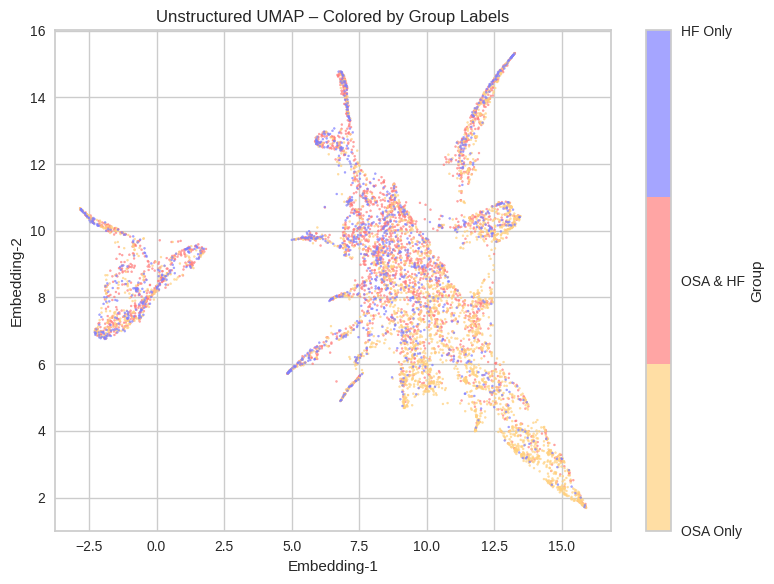

In [49]:
n_classes = len(np.unique(y_bert_train))  
compressed_text_test_128 = tabnet_encoder_embeddings(tabnet_txt_model, X_bert_test, n_classes)
print("Compressed text embeddings shape:", compressed_text_test_128.shape)

X_text_test_df = pd.DataFrame(compressed_text_test_128).reset_index(drop=True)
y_text_df = pd.DataFrame(y_bert_test, columns=['group']).reset_index(drop=True)
group_text_df = pd.DataFrame(test_keys, columns=['subject_id']).reset_index(drop=True)
X_text_test_all_df = pd.concat([X_text_test_df, y_text_df, group_text_df], axis=1).fillna(0)

# clustering (UMAP)
latent_representations_txt = compressed_text_test_128
clusterable_embedding_txt, runtime = umap_embedding(latent_representations_txt,n_components=2,n_neighbors=50,min_dist=0.1)

evaluate_kmeans(clusterable_embedding_txt, Y=y_bert_test, n_clusters=3)
label_mapping = {
    1.0: "HF Only",
    2.0: "OSA & HF",
    0.0: "OSA Only"}

named_labels_txt = pd.Series(y_bert_test).map(label_mapping)

label_to_color_txt = {
    "OSA Only": "#FFD580",    
    "OSA & HF": "#FF9999",    
    "HF Only": "#ADD8E6"}

plot_umap_with_custom_colorbar(clusterable_embedding=clusterable_embedding_txt,labels=named_labels_txt,title="Unstructured UMAP – Colored by Group Labels")

## ClinicalBert embeddings classification (KAN, RF, LR)

## RF & LR

In [50]:
#collect reuslts of RF and LR uncomment 2nd line if need results
train_models(X_text_test_all_df)


Training Logistic Regression
Logistic Regression - CrossVal: ROC AUC: 0.694 (Std: 0.012)
Logistic Regression - Runtime: 6.112431 seconds

Training Random Forest
Random Forest - CrossVal: ROC AUC: 0.683 (Std: 0.011)
Random Forest - Runtime: 61.696639 seconds


({'Logistic Regression': {'mean_score': 0.6935118037769804,
   'std_score': 0.012157162439530987,
   'runtime': 6.112430810928345},
  'Random Forest': {'mean_score': 0.6831818067158627,
   'std_score': 0.011144639988631619,
   'runtime': 61.6966392993927}},
 RandomForestClassifier(),
 LogisticRegression(C=0.2, max_iter=5000, multi_class='multinomial'))

## KAN model definition + training

In [51]:
# Convert text test embeddings to tensor for KAN model
X_kan_text = torch.tensor(compressed_text_test_128, dtype=torch.float32)
y_kan_text = torch.tensor(y_bert_test, dtype=torch.long)

input_dim = X_kan_text.shape[1]
num_classes = len(torch.unique(y_kan_text))


In [52]:
# define KAN model and train
model = KAN(width=[input_dim, 64, num_classes],grid=5,k=3,device='cpu',seed=42)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_kan_text)
    loss = criterion(outputs, y_kan_text)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


checkpoint directory created: ./model
saving model version 0.0
Epoch [10/50], Loss: 0.9876
Epoch [20/50], Loss: 0.9509
Epoch [30/50], Loss: 0.9366
Epoch [40/50], Loss: 0.9258
Epoch [50/50], Loss: 0.9199


In [53]:
model.eval()
with torch.no_grad():
    logits = model(X_kan_text)
    preds = torch.argmax(logits, dim=1)
    probs = torch.softmax(logits, dim=1).numpy()

    y_true = y_kan_text.numpy()
    pred_labels = preds.numpy()

In [54]:
print("Accuracy:", accuracy_score(y_true, pred_labels))
print("Classification Report:\n", classification_report(y_true, pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_true, pred_labels))

# ROC AUC (for multiclass)
if num_classes > 2:
    y_true_onehot = np.eye(num_classes)[y_true]
    print("ROC AUC (weighted, ovr):", roc_auc_score(y_true_onehot, probs, multi_class='ovr', average='weighted'))


Accuracy: 0.5707217694994179
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      2970
           1       0.57      0.04      0.08      1167
           2       0.52      0.70      0.60      2735

    accuracy                           0.57      6872
   macro avg       0.57      0.47      0.44      6872
weighted avg       0.58      0.57      0.53      6872

Confusion Matrix:
 [[1945   20 1005]
 [ 332   50  785]
 [ 790   18 1927]]
ROC AUC (weighted, ovr): 0.7111586081874384


# fuse embeddings (simple concatenation method)

In [55]:
#checking shape of fused emebddings should be (n_rows, 128) 
fused_test_256 = np.concatenate([embeddings_X_test, compressed_text_test_128], axis=1)
print(embeddings_X_test.shape)
print(compressed_text_test_128.shape)

(6872, 128)
(6872, 128)


In [56]:
#checking for mismatch between rows after fusion
structured_ids = group_df.copy()  
text_ids = test_keys[['subject_id', 'hadm_id']].copy()
structured_ids = structured_ids.reset_index(drop=True)
text_ids = text_ids.reset_index(drop=True)

# compare side by side
comparison = pd.concat([structured_ids, text_ids], axis=1)
comparison.columns = ['subject_id_structured', 'subject_id_text', 'hadm_id_text']
print(comparison.head(10))

# check how many rows mismatch after fusion
mismatches = (comparison['subject_id_structured'] != comparison['subject_id_text']).sum()
print(f" mismatched subject_id rows: {mismatches}")

   subject_id_structured  subject_id_text  hadm_id_text
0               18498678         18498678      26682480
1               13718173         13718173      24877794
2               18605545         18605545      24612358
3               10400173         10400173      21513894
4               18123897         18123897      28673600
5               16724979         16724979      24482310
6               17754293         17754293      21086123
7               17533213         17533213      24254190
8               18335994         18335994      27387000
9               16070958         16070958      21353729
 mismatched subject_id rows: 0


In [57]:
# convert to datafrme before running classification / clustering
X_fused_df = pd.DataFrame(fused_test_256).reset_index(drop=True)
y_fused_df = pd.DataFrame(y_bert_test, columns=['group']).reset_index(drop=True)
group_fused_df = pd.DataFrame(test_keys).reset_index(drop=True) 

print("X_fused shape:", fused_test_256.shape)
X_fused = fused_test_256

X_fused shape: (6872, 256)


In [58]:
# verify datafrme
print("group_fused_df shape:", group_fused_df.shape)
print(group_fused_df.head())

group_fused_df shape: (6872, 2)
   subject_id   hadm_id
0    18498678  26682480
1    13718173  24877794
2    18605545  24612358
3    10400173  21513894
4    18123897  28673600


In [59]:
# check group distribution of embeddings
print("y_fused_df shape:", y_fused_df.shape)
print(y_fused_df['group'].value_counts())

y_fused_df shape: (6872, 1)
group
0.0    2970
2.0    2735
1.0    1167
Name: count, dtype: int64


## fused classification (KAN, RF, LR)

In [60]:
#get results for LR, RF
X_fused_all_df = pd.concat([X_fused_df, y_fused_df, group_fused_df], axis=1).fillna(0)
train_models(X_fused_all_df)


Training Logistic Regression
Logistic Regression - CrossVal: ROC AUC: 0.885 (Std: 0.009)
Logistic Regression - Runtime: 8.126539 seconds

Training Random Forest
Random Forest - CrossVal: ROC AUC: 0.879 (Std: 0.009)
Random Forest - Runtime: 68.195000 seconds


({'Logistic Regression': {'mean_score': 0.8848985807597443,
   'std_score': 0.008807336122021581,
   'runtime': 8.126538515090942},
  'Random Forest': {'mean_score': 0.8793560427463,
   'std_score': 0.008936109039046574,
   'runtime': 68.19499969482422}},
 RandomForestClassifier(),
 LogisticRegression(C=0.2, max_iter=5000, multi_class='multinomial'))

In [62]:
# data prep for KAN model
# Convert text test embeddings to tensor for KAN model
X_kan_fused = torch.tensor(X_fused_df.values, dtype=torch.float32)
y_kan_fused = torch.tensor(y_fused_df['group'].values, dtype=torch.long)

input_dim = X_kan_text.shape[1]
num_classes = len(torch.unique(y_kan_text))

In [64]:
# define KAN model and train
model = KAN(width=[input_dim, 64, num_classes],grid=5,k=3,device='cpu',seed=42)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_kan_fused)
    loss = criterion(outputs, y_kan_fused)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

checkpoint directory created: ./model
saving model version 0.0
Epoch [10/50], Loss: 0.8897
Epoch [20/50], Loss: 0.7562
Epoch [30/50], Loss: 0.6722
Epoch [40/50], Loss: 0.6260
Epoch [50/50], Loss: 0.6075


In [65]:
model.eval()
with torch.no_grad():
    logits = model(X_kan_fused)
    preds = torch.argmax(logits, dim=1)
    probs = torch.softmax(logits, dim=1).numpy()

    y_true = y_kan_fused.numpy()
    pred_labels = preds.numpy()

# Metrics
print("Accuracy:", accuracy_score(y_true, pred_labels))
print("\nClassification Report:\n", classification_report(y_true, pred_labels))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, pred_labels))

Accuracy: 0.7447613504074505

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      2970
           1       0.57      0.27      0.37      1167
           2       0.69      0.84      0.76      2735

    accuracy                           0.74      6872
   macro avg       0.70      0.65      0.65      6872
weighted avg       0.73      0.74      0.73      6872


Confusion Matrix:
 [[2499   88  383]
 [ 203  314  650]
 [ 280  150 2305]]


In [66]:
# ROC AUC (for multiclass)
if num_classes > 2:
    y_true_onehot = np.eye(num_classes)[y_true]
    print("ROC AUC (weighted, ovr):", roc_auc_score(y_true_onehot, probs, multi_class='ovr', average='weighted'))


ROC AUC (weighted, ovr): 0.8938281558463392


## fused UMAP clustering metrics

UMAP Runtime: 12.152555 seconds
Adjusted Rand Index: 0.005789336035439399
Silhouette Score: 0.7354984879493713
Davies-Bouldin Index: 0.47779054154004247
Within-Cluster Sum of Squares (WCSS): 61238.92578125


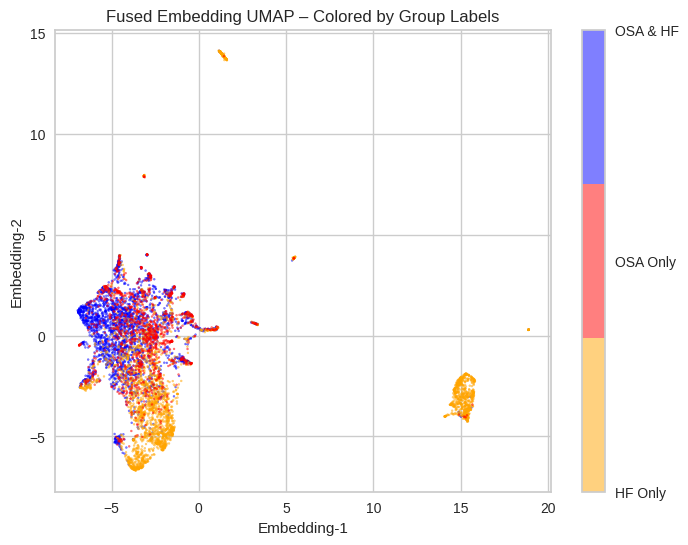

In [62]:
latent_representations_fused = fused_test_256
clusterable_embedding_fused, runtime = umap_embedding(latent_representations_fused,n_components=2, n_neighbors=50, min_dist=0.1)

evaluate_kmeans(clusterable_embedding_fused, Y=y_bert_test, n_clusters=3)
plot_umap_embedding(
    clusterable_embedding_fused,
    labels=pd.Series(y_bert_test),
    group=list(np.unique(y_bert_test)),
    colors=['orange', 'red', 'blue'],
    point_size=2,
    title="Fused Embedding UMAP – Colored by Group Labels")


## clustering plot for fused embeddings

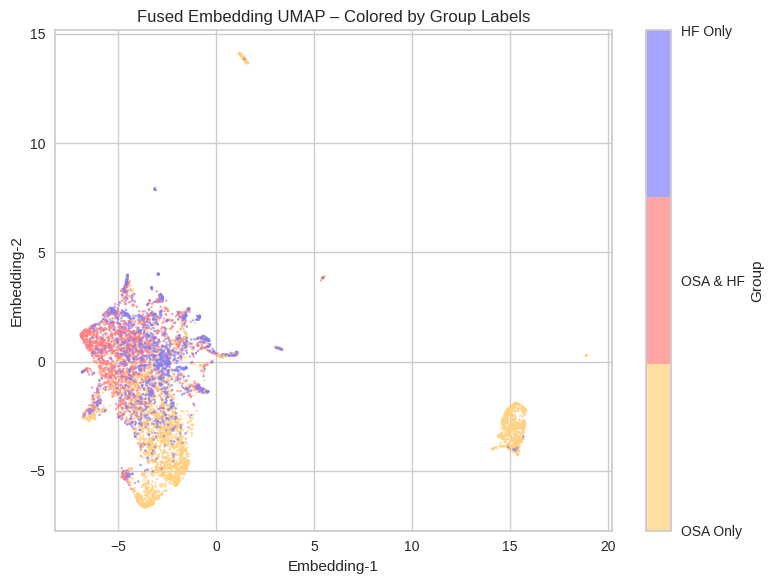

In [64]:
# updated label mapping
label_mapping = {
    1.0: "HF Only",
    2.0: "OSA & HF",
    0.0: "OSA Only"}
named_labels = pd.Series(y_bert_test).map(label_mapping)
plot_umap_with_custom_colorbar(
    clusterable_embedding_fused,
    labels=named_labels,
    title="Fused Embedding UMAP – Colored by Group Labels")

# HDBSCAN analysis on fused embeddings split into two groups (OSA only)

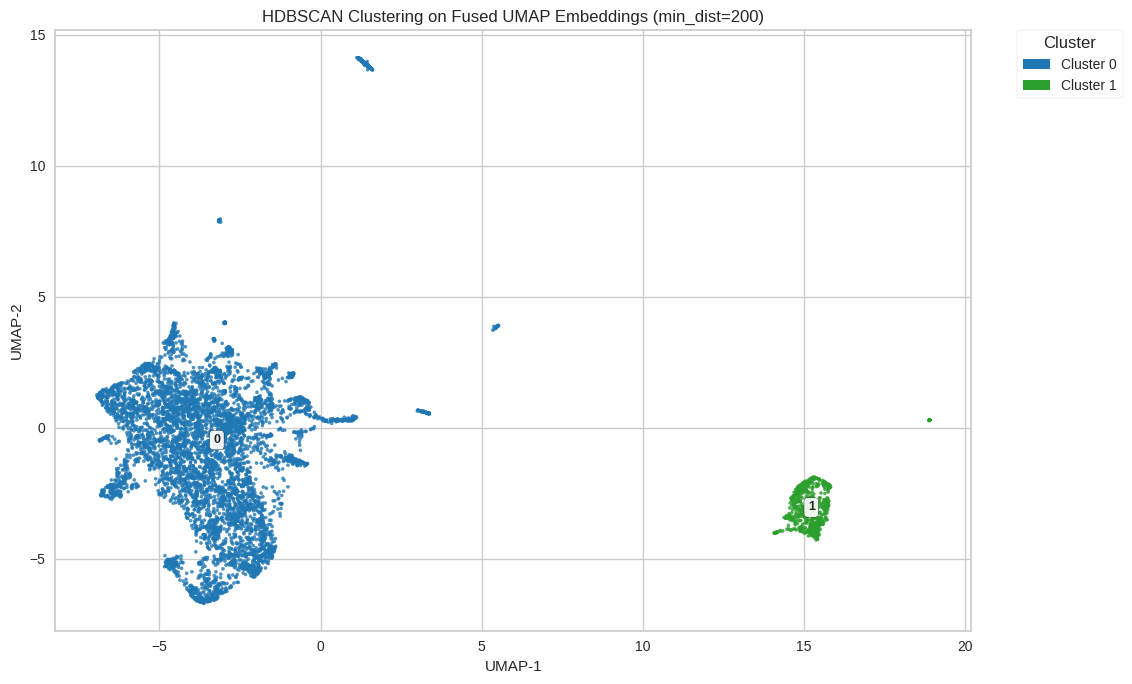

Cluster counts: {0: 6191, 1: 681}


In [65]:
fused_umap_embedding = UMAP(n_neighbors=50,min_dist=0.1, n_components=2,random_state=42).fit_transform(fused_test_256)
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=10)
hdb_labels = clusterer.fit_predict(fused_umap_embedding)

dark_palette = [
    "#1f77b4",  # dark blue
    "#2ca02c",  # dark green
    "#d62728",  # dark red
    "#9467bd",  # dark purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # olive
    "#17becf",  # cyan
    "#ff7f0e"   # orange
]
unique_clusters = np.unique(hdb_labels)
cluster_to_color = {
    label: dark_palette[i % len(dark_palette)]
    for i, label in enumerate(unique_clusters)}

# Assign color to each point (noise = black)
point_colors = [cluster_to_color[label] if label != -1 else "black" for label in hdb_labels]

#plot cluster labels
plt.figure(figsize=(10, 7))
plt.scatter(fused_umap_embedding[:, 0],fused_umap_embedding[:, 1],c=point_colors,s=5,alpha=0.8)

# annotate centroids with cluster numbers
for cluster in unique_clusters:
    if cluster == -1:
        continue 
    cluster_points = fused_umap_embedding[hdb_labels == cluster]
    centroid = cluster_points.mean(axis=0)
    plt.text(
        centroid[0], centroid[1],
        str(cluster),
        fontsize=9,
        weight='bold',
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3'))

plt.title("HDBSCAN Clustering on Fused UMAP Embeddings (min_dist=200)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()

# color legend 
legend_elements = [
    Patch(facecolor=cluster_to_color[label], label=f'Cluster {label}')
    if label != -1 else
    Patch(facecolor="black", label='Noise (-1)')
    for label in unique_clusters]

plt.legend(handles=legend_elements,title="Cluster",bbox_to_anchor=(1.05, 1), loc='upper left',borderaxespad=0.,frameon=True)
plt.show()

# cluster size summary
unique, counts = np.unique(hdb_labels, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))
osa_mask = (y_bert_test == 0)
ids_osa = test_keys[osa_mask].reset_index(drop=True)
osa_cluster_labels = np.array(hdb_labels)[osa_mask]

# Create dataframe for survival merge
osa_top_clusters_df = ids_osa.copy()
osa_top_clusters_df["cluster"] = osa_cluster_labels
cluster_color_map = {
    0: "#1f77b4",  
    1: "#2ca02c"}

In [66]:
# view the two segmented clusters
osa_top_clusters_df

,subject_id,hadm_id,cluster
0,18203391,20006478,0
1,11620358,20009524,0
2,13734687,20015644,0
3,19732362,20018249,1
4,16291026,20018618,0
...,...,...,...
2965,16291026,29981511,1
2966,12407328,29993869,0
2967,17805551,29995960,0
2968,15392823,29996893,1


OSA-only UMAP shape: (2970, 2)


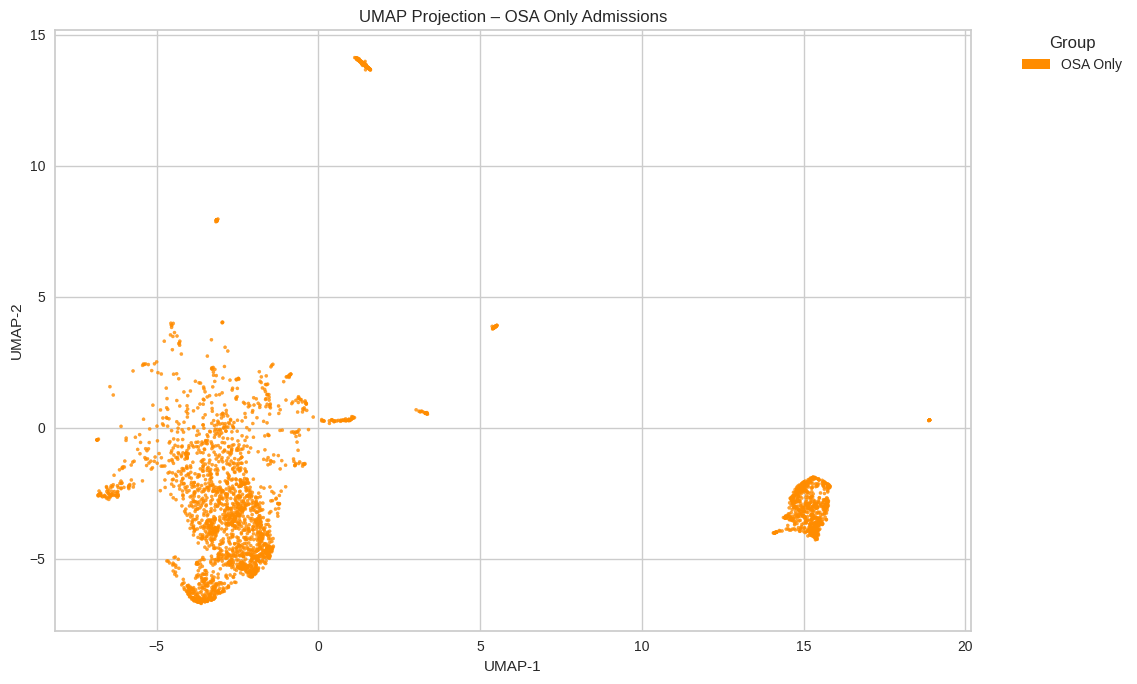

In [67]:
# filter down to only OSA admissions on the fused HDBSCAN plot
osa_mask = (y_bert_test == 0)
osa_umap_filtered = fused_umap_embedding[osa_mask]
print("OSA-only UMAP shape:", osa_umap_filtered.shape)
osa_color = "#ff8c00" 
point_colors = [osa_color] * osa_umap_filtered.shape[0]

#  Plot UMAP (OSA Only) 
plt.figure(figsize=(10, 7))
plt.scatter(osa_umap_filtered[:, 0],osa_umap_filtered[:, 1],c=point_colors,s=5,alpha=0.8)

plt.title("UMAP Projection – OSA Only Admissions")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()

#Add legend 
legend_patch = Patch(facecolor=osa_color, label="OSA Only")
plt.legend(handles=[legend_patch],title="Group",bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)
plt.show()

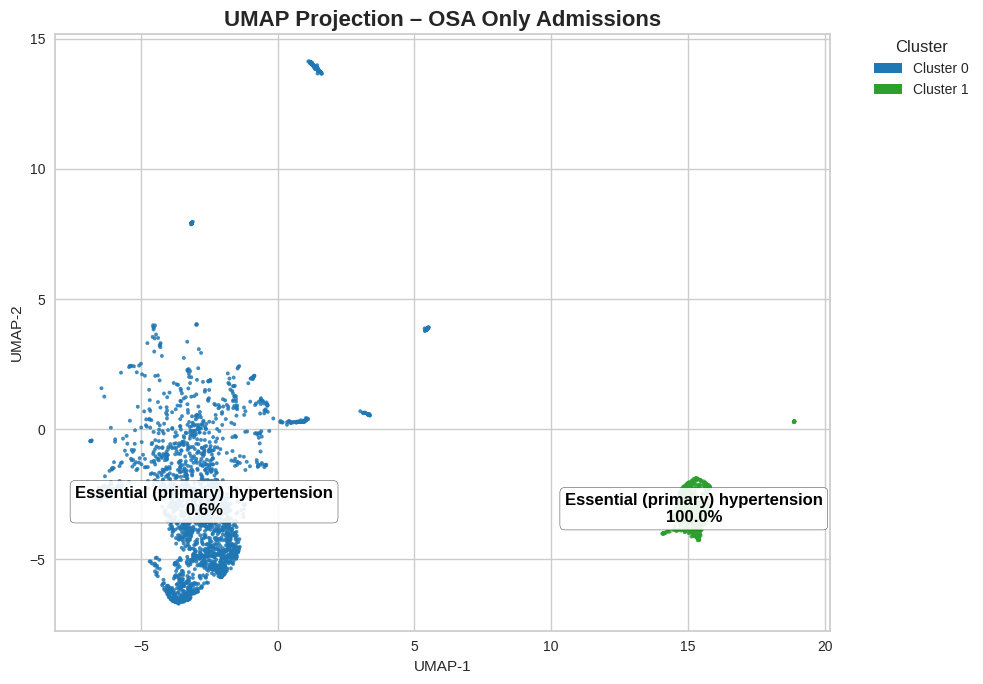

In [70]:
# use the same plot except overlay the top impotrant feature from tabnet model
try:
    cluster_labels
except NameError:
    kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(osa_umap_filtered)
cluster_color_map = {0: "#1f77b4", 1: "#2ca02c"}
point_colors = [cluster_color_map[c] for c in cluster_labels]

# --- Feature values: Essential (primary) hypertension (binary) ---
feat_col = "Essential (primary) hypertension"
assert feat_col in osa_structured_df.columns, f"missing column: {feat_col}"
feature_vals = (osa_structured_df[feat_col].values > 0).astype(int)  # 1=present, 0=absent
assert len(feature_vals) == osa_umap_filtered.shape[0], "Feature/UMAP length mismatch."

# Plot points colored by cluster 
plt.figure(figsize=(10,7))
plt.scatter(osa_umap_filtered[:,0],osa_umap_filtered[:,1],c=point_colors,s=6,alpha=0.85)
plt.title("UMAP Projection – OSA Only Admissions", fontsize=16, fontweight='bold')
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")

# overlay per-cluster label + percentage for the feature 
for cid in np.unique(cluster_labels):
    pts = osa_umap_filtered[cluster_labels == cid]
    if pts.size == 0: 
        continue
    x_med, y_med = np.median(pts[:,0]), np.median(pts[:,1])
    pct = 100.0 * feature_vals[cluster_labels == cid].mean()
    txt = f"Essential (primary) hypertension\n{pct:.1f}%"
    plt.text(
        x_med, y_med, txt,
        ha='center', va='center',
        fontsize=12, weight='bold',
        color='black',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9, boxstyle='round,pad=0.3'))

# Legend for cluster colors 
legend_elements = [Patch(facecolor=cluster_color_map[c], label=f'Cluster {c}') for c in sorted(np.unique(cluster_labels))]
plt.legend(handles=legend_elements, title="Cluster", bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


## investgate difference bwtween clusters

In [68]:
# filter structured dataframe to test set first
test_structured_df = X_test.reset_index(drop=True)
test_structured_df['subject_id'] = test_keys['subject_id'].reset_index(drop=True)
test_structured_df['hadm_id'] = test_keys['hadm_id'].reset_index(drop=True)
test_structured_df['group'] = y_test.reset_index(drop=True)

# filter to OSA-only (group == 0)
osa_structured_df = test_structured_df[test_structured_df['group'] == 0].reset_index(drop=True)

# check for feature existence
features_to_plot = [
    "Other and unspecified hyperlipidemia",
    "Personal history of tobacco use",
    "Depressive disorder, not elsewhere classified",
    "Essential (primary) hypertension"]

for feat in features_to_plot:
    assert feat in osa_structured_df.columns, f"Feature not found: {feat}"

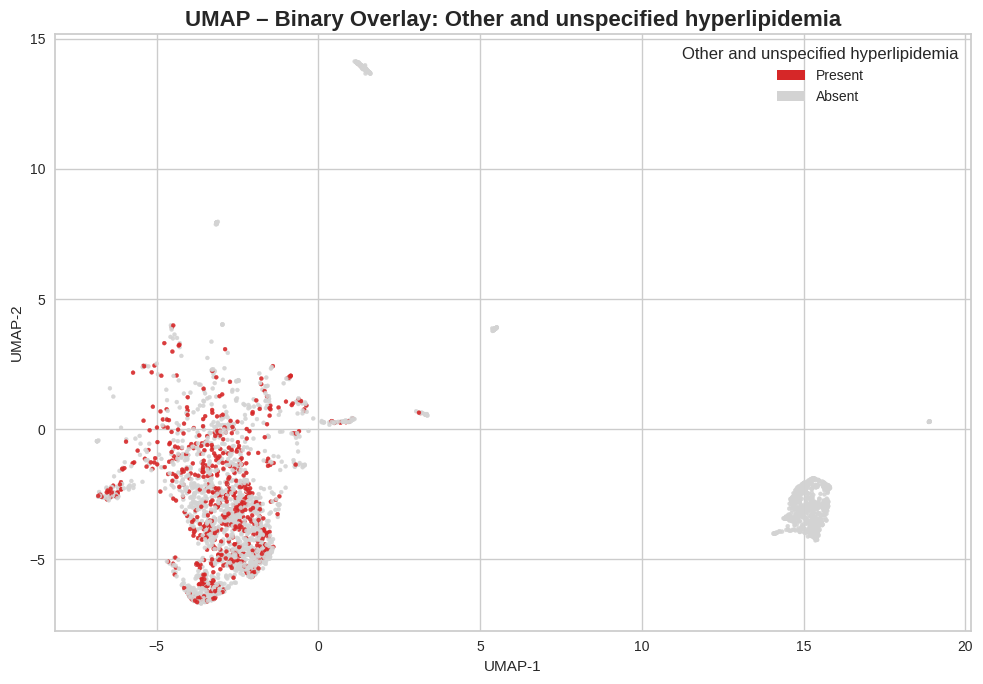

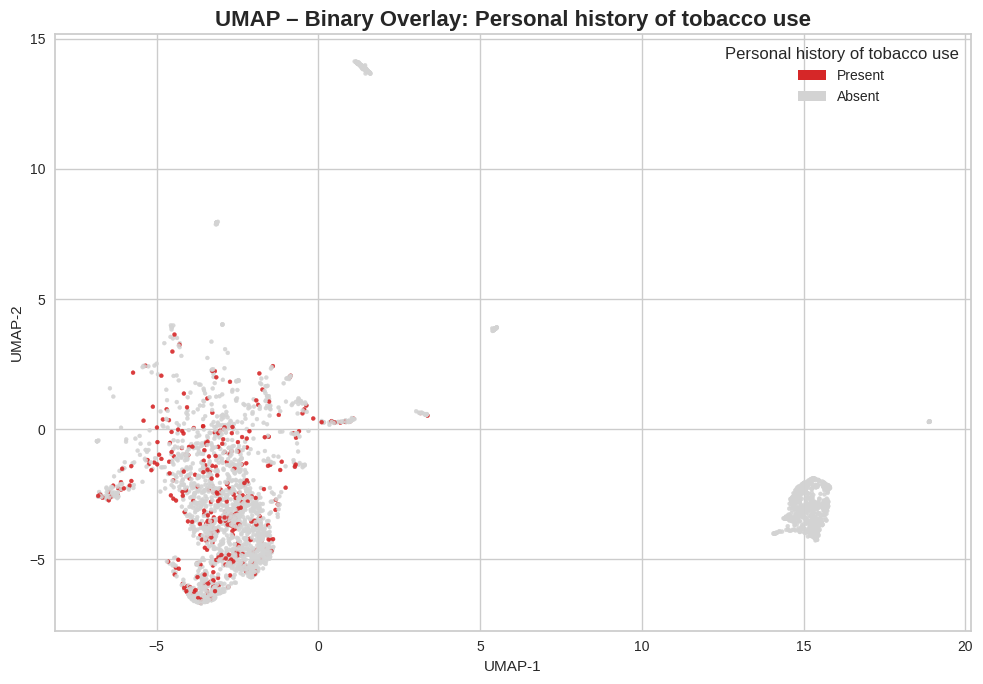

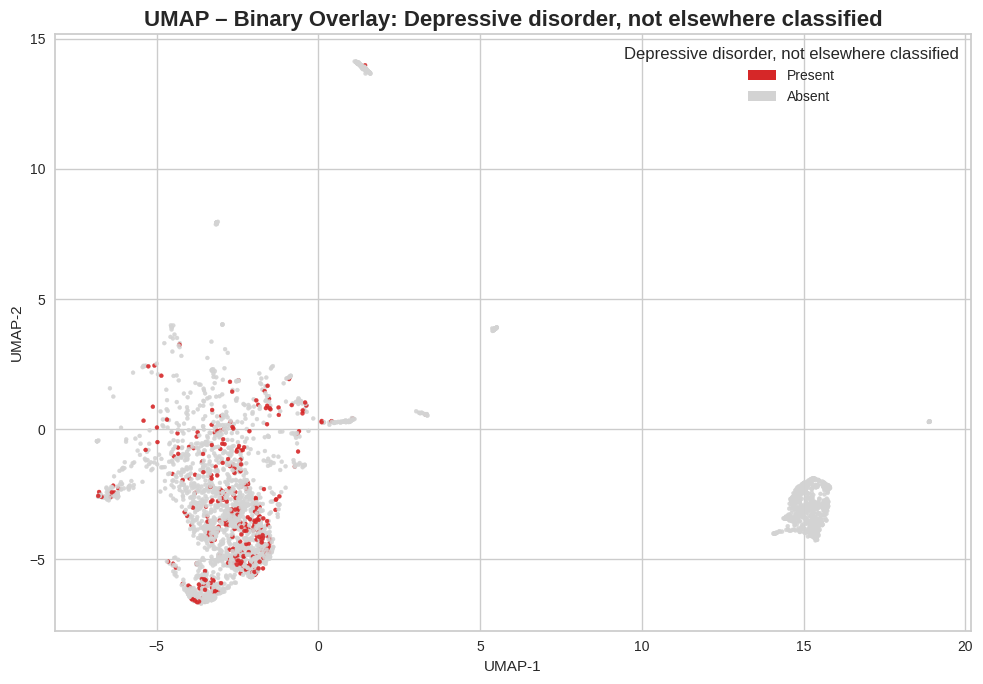

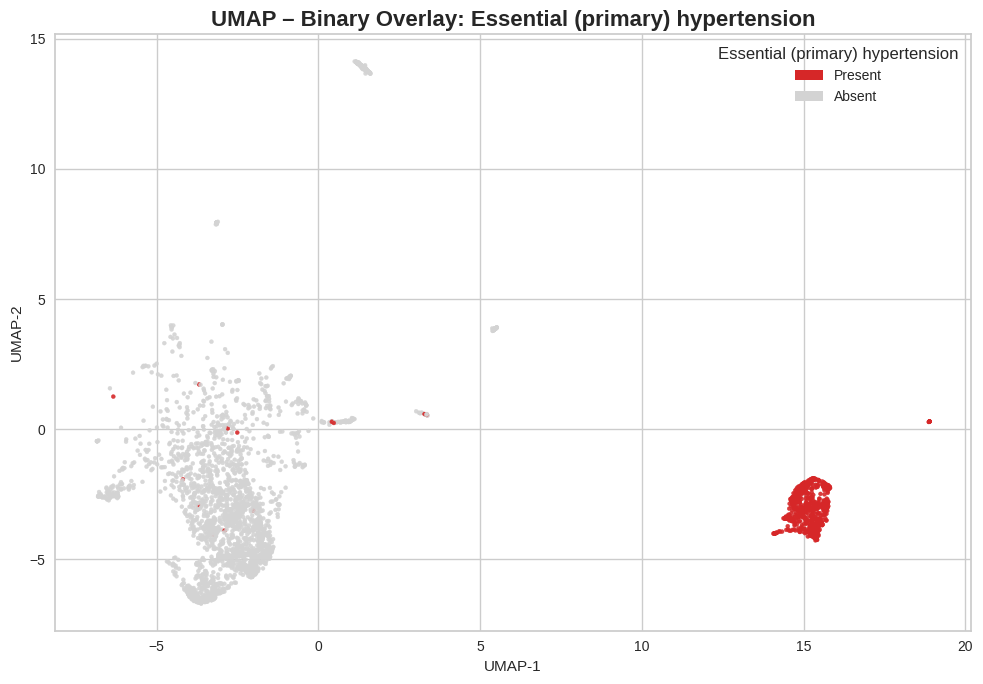

In [71]:
# plot all features on fused plots to see diatribution of patietns with feature per cluster
for feat in features_to_plot:
    plot_binary_feature_overlay_umap(
        embedding=osa_umap_filtered,
        feature_values=osa_structured_df[feat].values,
        feature_name=feat)

# load data for survival analysis of patients

In [74]:
# Load required MIMIC-IV tables (all sophia code)
labevents = pd.read_csv(mimic4_path + 'hosp/labevents.csv', low_memory=False)
d_labitems = pd.read_csv(mimic4_path + 'hosp/d_labitems.csv')
admissions = pd.read_csv(mimic4_path + 'hosp/admissions.csv')
patients = pd.read_csv(mimic4_path + 'hosp/patients.csv')

# Convert date fields
admissions["admittime"] = pd.to_datetime(admissions["admittime"])
admissions["dischtime"] = pd.to_datetime(admissions["dischtime"])
patients["dod"] = pd.to_datetime(patients["dod"])

# Compute length of stay
if 'los' not in admissions.columns:
    admissions["los"] = (admissions["dischtime"] - admissions["admittime"]).dt.total_seconds() / (60 * 60 * 24)

In [75]:
# Merge cluster assignments with admission and mortality info -- adapted sophia code
data_survival = osa_top_clusters_df.merge(admissions[['subject_id', 'hadm_id', 'admittime', 'hospital_expire_flag', 'los']],on=['subject_id', 'hadm_id'],how='left')
data_survival = data_survival.merge(patients[['subject_id', 'dod']],on='subject_id',how='left')

data_survival["admittime"] = pd.to_datetime(data_survival["admittime"])
data_survival["dod"] = pd.to_datetime(data_survival["dod"])


In [76]:
tqdm.pandas()

# Init fields
data_survival["30_day_mortality"] = 0
data_survival["1_year_mortality"] = 0
data_survival["time_30_day_mortality"] = np.nan
data_survival["time_1_year_mortality"] = np.nan

# Mortality logic
def died_within_n_days(row, time_in_days, mortality_type):
    if pd.isna(row["dod"]):
        row[f"time_{mortality_type}_mortality"] = time_in_days
        row[f"{mortality_type}_mortality"] = 0
    else:
        days = (row["dod"] - row["admittime"]).days
        if days <= time_in_days:
            row[f"time_{mortality_type}_mortality"] = days
            row[f"{mortality_type}_mortality"] = 1
        else:
            row[f"time_{mortality_type}_mortality"] = time_in_days
            row[f"{mortality_type}_mortality"] = 0
    return row

# Apply both
data_survival = data_survival.progress_apply(died_within_n_days, axis=1, time_in_days=30, mortality_type='30_day')
data_survival = data_survival.progress_apply(died_within_n_days, axis=1, time_in_days=365, mortality_type='1_year')

# Remove bad rows
data_survival = data_survival[data_survival['time_30_day_mortality'] >= 0]
data_survival = data_survival[data_survival['time_1_year_mortality'] >= 0]

100%|██████████| 2970/2970 [00:00<00:00, 25888.13it/s]


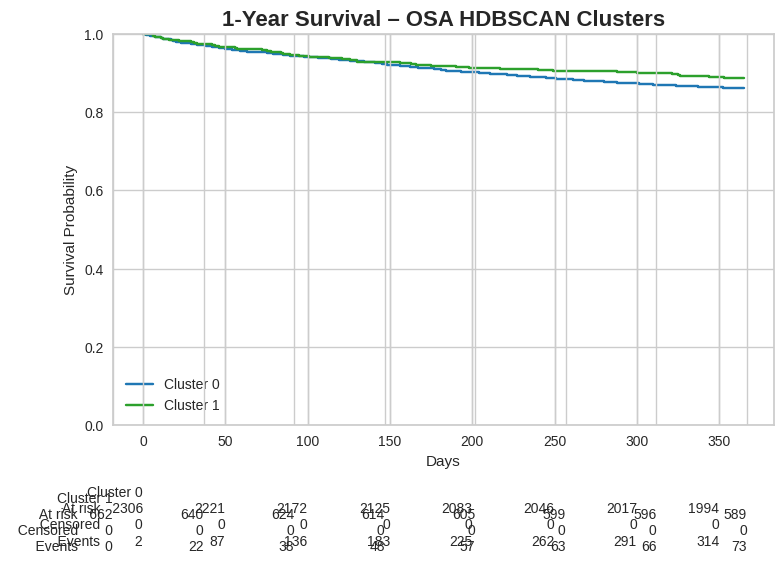

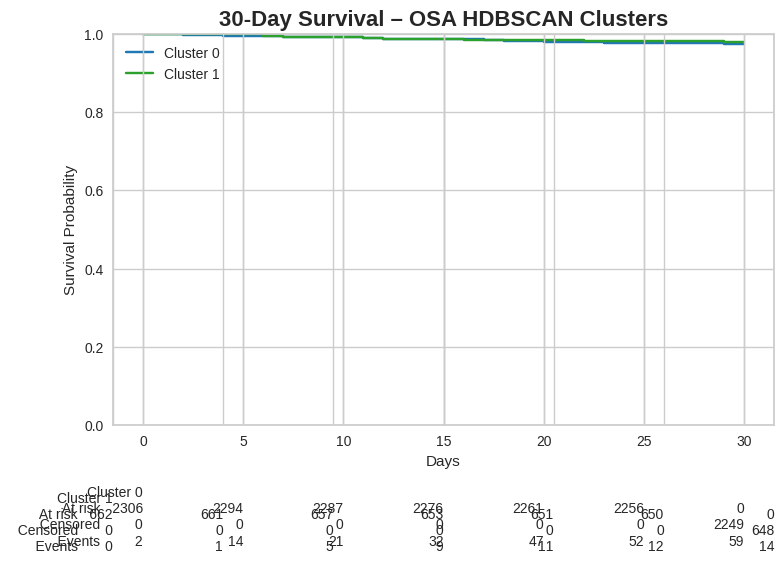

In [89]:
# create pltos for survival trend lines for each OSA cluster
cluster_color_map = {
    0: "#1f77b4",  
    1: "#2ca02c",}

top_clusters = sorted(data_survival["cluster"].unique())

# 1-Year Survival 
T = data_survival["time_1_year_mortality"]
E = data_survival["1_year_mortality"]

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for cluster in top_clusters:
    mask = (data_survival["cluster"] == cluster)
    if mask.sum() == 0:
        continue
    kmf.fit(durations=T[mask], event_observed=E[mask], label=f"Cluster {cluster}")
    kmf.plot_survival_function(ax=ax, at_risk_counts=True, color=cluster_color_map.get(cluster, "gray"), ci_show=False)

ax.set_title("1-Year Survival – OSA HDBSCAN Clusters", fontsize=16, fontweight='bold')
ax.set_xlabel("Days")
ax.set_ylabel("Survival Probability")
plt.ylim(0, 1)
plt.xlim(0, 365)
plt.tight_layout()
plt.show()

# 30-Day Survival 
T = data_survival["time_30_day_mortality"]
E = data_survival["30_day_mortality"]

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

for cluster in top_clusters:
    mask = (data_survival["cluster"] == cluster)
    if mask.sum() == 0:
        continue
    kmf.fit(durations=T[mask], event_observed=E[mask], label=f"Cluster {cluster}")
    kmf.plot_survival_function(ax=ax, at_risk_counts=True, color=cluster_color_map.get(cluster, "gray"), ci_show=False)

ax.set_title("30-Day Survival – OSA HDBSCAN Clusters", fontsize=16, fontweight='bold')
ax.set_xlabel("Days")
ax.set_ylabel("Survival Probability")
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.tight_layout()
plt.show()

## plot charlson score on each cluster

In [92]:
# Unscale and round Charlson score back to integers
osa_structured_df['charlson_raw'] = (osa_structured_df['charlson'] * 10).round().astype(int)

In [93]:
# Bin raw Charlson scores: 0, 1, 2, 3, 4+
osa_structured_df['charlson_bin'] = osa_structured_df['charlson_raw'].apply(lambda x: str(x) if x < 4 else "4+")

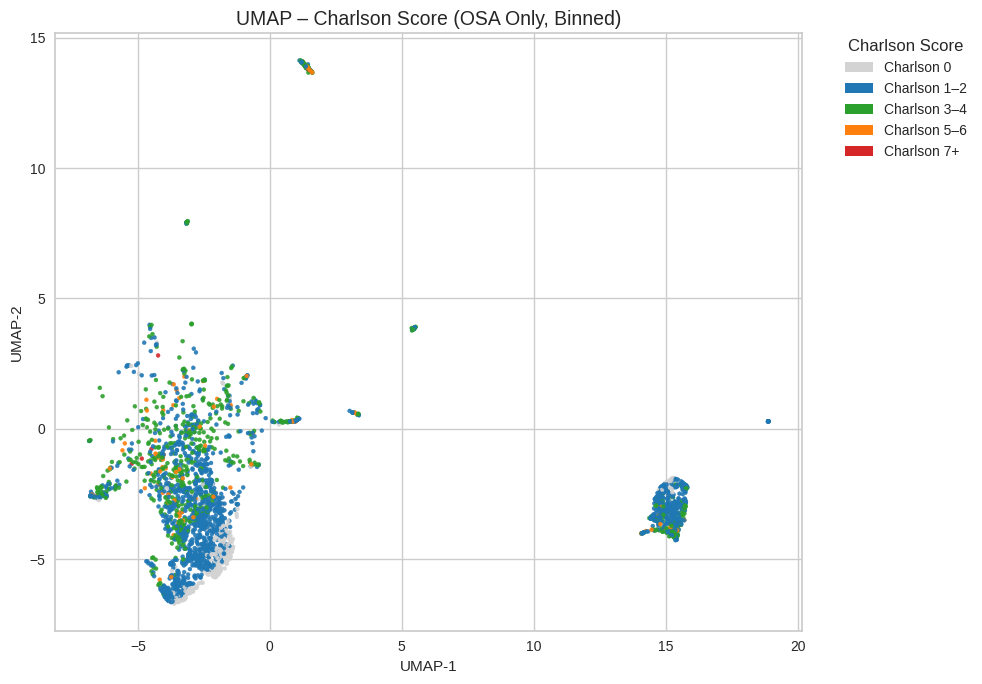

In [96]:
# unscale Charlson score to raw range 
charlson_raw = (osa_structured_df['charlson_raw']
charlson_bins = charlson_raw.apply(bin_charlson)

# assign solid colors to each bin 
bin_color_map = {
    "0": "#d3d3d3",
    "1–2": "#1f77b4",
    "3–4": "#2ca02c",
    "5–6": "#ff7f0e",
    "7+": "#d62728"}

point_colors = charlson_bins.map(bin_color_map)

In [ ]:
# plot the UMAP with Charlson overlay 
plt.figure(figsize=(10, 7))
plt.scatter(osa_umap_filtered[:, 0],osa_umap_filtered[:, 1],c=point_colors,s=8,alpha=0.9)

legend_elements = [
    Patch(facecolor=bin_color_map[key], label=f"Charlson {key}")
    for key in ["0", "1–2", "3–4", "5–6", "7+"]]

plt.legend(handles=legend_elements,title="Charlson Score",bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)
plt.title("UMAP – Charlson Score (OSA Only, Binned)", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [109]:
# manually added patient id (selected at random) to view trajectory
target_patient_ids = [11132535]  
cluster_color_map = {
    0: "#1f77b4",  
    1: "#2ca02c"}

In [97]:
# track patient transition
osa_top_clusters_df['subject_id'] = osa_top_clusters_df['subject_id'].astype(int)
osa_top_clusters_df['hadm_id'] = osa_top_clusters_df['hadm_id'].astype(int)
admissions['subject_id'] = admissions['subject_id'].astype(int)
admissions['hadm_id'] = admissions['hadm_id'].astype(int)

# merge in admission time info
print("\nMerging admittime into OSA cluster data...")
admit_info = admissions[['subject_id', 'hadm_id', 'admittime']].drop_duplicates()
osa_top_clusters_df = pd.merge(osa_top_clusters_df, admit_info, on=['subject_id', 'hadm_id'], how='left')


Merging admittime into OSA cluster data...


In [98]:
# find patietns with more than 5 admissions to track the paths
print("\nFinding patients with >5 admissions and cluster transitions...")

# Sort and track transitions
cluster_transitions = (
    osa_top_clusters_df[['subject_id', 'hadm_id', 'admittime', 'cluster']]
    .dropna()
    .sort_values(['subject_id', 'admittime']).copy())
cluster_transitions['prev_cluster'] = cluster_transitions.groupby('subject_id')['cluster'].shift(1)
cluster_transitions['cluster_changed'] = cluster_transitions['cluster'] != cluster_transitions['prev_cluster']

# filter patients with >5 admissions
admission_counts = cluster_transitions.groupby('subject_id').size()
valid_patients = admission_counts[admission_counts > 5].index

# find patients with at least one cluster change
patient_changes = cluster_transitions[
    (cluster_transitions['subject_id'].isin(valid_patients)) &
    (cluster_transitions['cluster_changed'])]['subject_id'].unique()

print(f"Found {len(patient_changes)} valid patients with >5 admissions and cluster changes.")


Finding patients with >5 admissions and cluster transitions...
Found 102 valid patients with >5 admissions and cluster changes.


In [99]:
# Create df_vis from UMAP output + IDs
df_vis = ids_osa.copy().reset_index(drop=True)
df_vis['UMAP1'] = osa_umap_filtered[:, 0]
df_vis['UMAP2'] = osa_umap_filtered[:, 1]

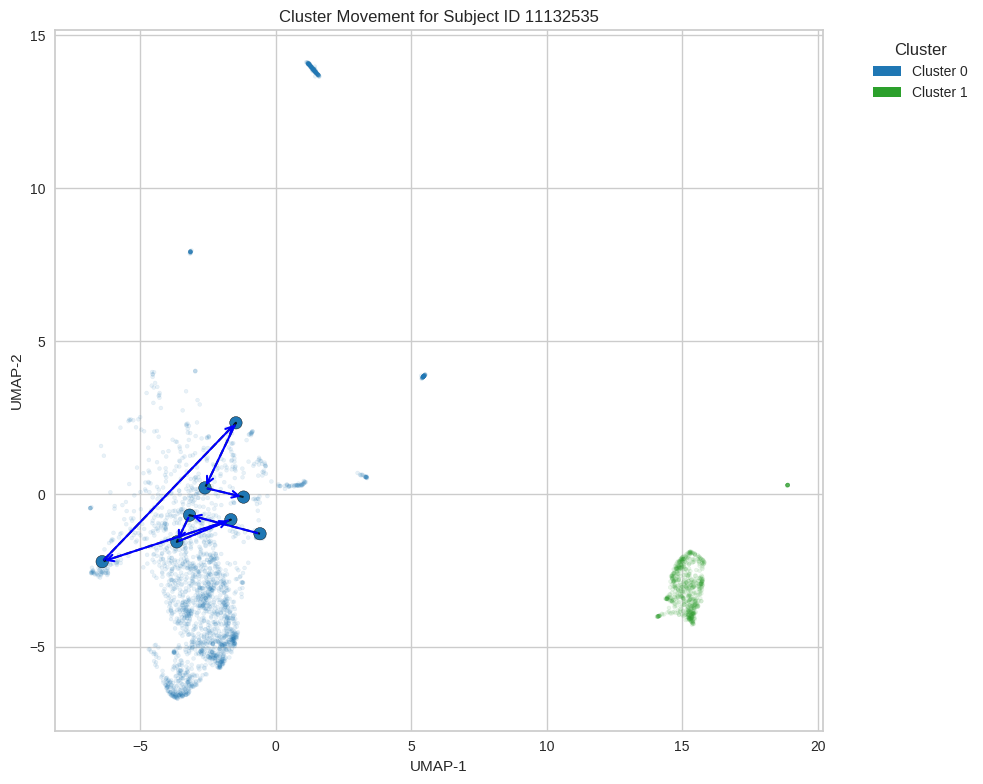

In [110]:
# Merge cluster for background
background_df = df_vis.merge(
    osa_top_clusters_df[['subject_id', 'hadm_id', 'cluster']],
    on=['subject_id', 'hadm_id'],how='left')

for patient_id in target_patient_ids:
    patient_df = cluster_transitions[cluster_transitions['subject_id'] == patient_id].copy()
    patient_df = patient_df.sort_values('admittime')

    if len(patient_df) < 2:
        print(f"Skipping subject {patient_id} (not enough transitions)")
        continue

    patient_df = patient_df.merge(df_vis, on=['subject_id', 'hadm_id'], how='left').dropna()
    patient_df.rename(columns={'UMAP1': 'UMAP', 'UMAP2': 'UMAP_Y'}, inplace=True)

    plt.figure(figsize=(10, 8))
    plt.scatter(background_df['UMAP1'],background_df['UMAP2'],c=background_df['cluster'].map(cluster_color_map),s=8,alpha=0.1)

    # Line connecting visits
    plt.plot(patient_df['UMAP'],patient_df['UMAP_Y'],color='black',linewidth=1.5,linestyle='--',alpha=0.8)

    # Cluster-colored points for each admission
    plt.scatter(
        patient_df['UMAP'],
        patient_df['UMAP_Y'],
        c=patient_df['cluster'].map(cluster_color_map),
        s=80, edgecolor='black')

    # Arrows
    for i in range(len(patient_df) - 1):
        x1, y1 = patient_df.iloc[i][['UMAP', 'UMAP_Y']]
        x2, y2 = patient_df.iloc[i + 1][['UMAP', 'UMAP_Y']]
        plt.annotate(
            "",
            xy=(x2, y2), xytext=(x1, y1),
            arrowprops=dict(arrowstyle="->", color='blue', lw=1.5))

    # Legend
    legend_elements = [
        Patch(facecolor=color, label=f'Cluster {cluster_id}')
        for cluster_id, color in cluster_color_map.items()]
    
    plt.legend(handles=legend_elements,title="Cluster",loc='upper left',bbox_to_anchor=(1.05, 1))
    plt.title(f"Cluster Movement for Subject ID {patient_id}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()


In [136]:
# Combine into one DataFrame for comparison (analysis of num transitiions vs admissions)
summary = pd.DataFrame({
    'admissions': admission_counts,
    'cluster_switches': switch_counts}).fillna(0).astype(int)

print("\n Admissions vs. Cluster Switches (sample):")
print(summary.head(10))
print(summary.info)


 Admissions vs. Cluster Switches (sample):
            admissions  cluster_switches
subject_id                              
10002221             5                 1
10014354             8                 6
10020306             1                 1
10020740             3                 1
10030753            15                 3
10032409             2                 1
10048105             3                 1
10049782             2                 1
10057126             2                 1
10065767             2                 1
<bound method DataFrame.info of             admissions  cluster_switches
subject_id                              
10002221             5                 1
10014354             8                 6
10020306             1                 1
10020740             3                 1
10030753            15                 3
...                ...               ...
19945152             6                 1
19958501             2                 1
19959697             2

In [ ]:
X_tensor = torch.tensor(X_fused, dtype=torch.float32)
y_tensor = torch.tensor(y_fused_df['group'].values, dtype=torch.long)

print("X_tensor shape:", X_tensor.shape)
print("y_tensor shape:", y_tensor.shape)
print("Label distribution:", np.bincount(y_tensor.numpy()))

# create full dataset 
full_dataset = TensorDataset(X_tensor, y_tensor)

# Split (80/10/10) 
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

# DataLoaders 
batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [ ]:

# define model
input_dim = X_tensor.shape[1]
kan_model = KAN(width=[input_dim, 64, 32, 3], grid=10, k=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(kan_model.parameters(), lr=1e-3)

In [88]:

# train
epochs = 20
for epoch in range(epochs):
    kan_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = kan_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")


X_tensor shape: torch.Size([6872, 256])
y_tensor shape: torch.Size([6872])
Label distribution: [2970 1167 2735]
Train: 5497, Val: 687, Test: 688
checkpoint directory created: ./model
saving model version 0.0
Epoch 1 - Loss: 0.9138
Epoch 2 - Loss: 0.6786
Epoch 3 - Loss: 0.6284
Epoch 4 - Loss: 0.5976
Epoch 5 - Loss: 0.5858
Epoch 6 - Loss: 0.5778
Epoch 7 - Loss: 0.5673
Epoch 8 - Loss: 0.5674
Epoch 9 - Loss: 0.5509
Epoch 10 - Loss: 0.5425
Epoch 11 - Loss: 0.5272
Epoch 12 - Loss: 0.5170
Epoch 13 - Loss: 0.4985
Epoch 14 - Loss: 0.4754
Epoch 15 - Loss: 0.4408
Epoch 16 - Loss: 0.4106
Epoch 17 - Loss: 0.3697
Epoch 18 - Loss: 0.3203
Epoch 19 - Loss: 0.2618
Epoch 20 - Loss: 0.2206

--- KAN Classification Report on Fused Embeddings ---
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       287
           1       0.38      0.37      0.37       104
           2       0.74      0.77      0.75       297

    accuracy                           0.74     

In [ ]:
# eval model performance
kan_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = kan_model(xb)
        predicted = preds.argmax(dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print("\n--- KAN Classification Report on Fused Embeddings ---")
print(classification_report(all_labels, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("Test Accuracy:", accuracy_score(all_labels, all_preds))

# explore diff between OSA clusters

In [61]:
df_umap = pd.DataFrame(clusterable_embedding_ae, columns=["x", "y"]).reset_index(drop=True)
df_umap["group"] = X_test_all_df["group"].reset_index(drop=True)

# keep only OSA-only patients
osa_df = df_umap[df_umap["group"] == 0].copy()
osa_indices = osa_df.index

# attach structured features
X_struct_osa = X_test.reset_index(drop=True).iloc[osa_indices]


In [62]:
# k means clustering on full df
kmeans = KMeans(n_clusters=2, random_state=0)
osa_df["subcluster"] = kmeans.fit_predict(osa_df[["x", "y"]])
osa_df = pd.concat([osa_df.reset_index(drop=True), X_struct_osa.reset_index(drop=True)], axis=1)

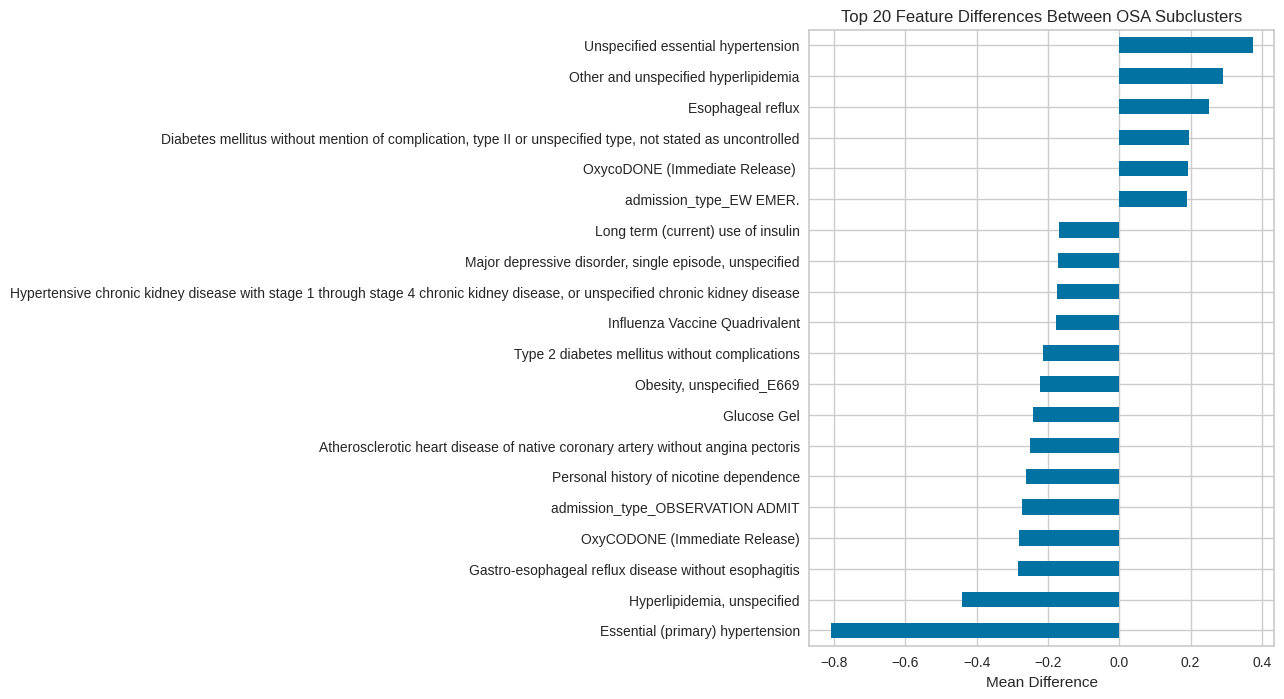

Top 20 differentiating features between OSA subclusters:
1. Essential (primary) hypertension
2. Hyperlipidemia, unspecified
3. Gastro-esophageal reflux disease without esophagitis
4. OxyCODONE (Immediate Release)
5. admission_type_OBSERVATION ADMIT
6. Personal history of nicotine dependence
7. Atherosclerotic heart disease of native coronary artery without angina pectoris
8. Glucose Gel
9. Obesity, unspecified_E669
10. Type 2 diabetes mellitus without complications
11. Influenza Vaccine Quadrivalent
12. Hypertensive chronic kidney disease with stage 1 through stage 4 chronic kidney disease, or unspecified chronic kidney disease
13. Major depressive disorder, single episode, unspecified
14. Long term (current) use of insulin
15. admission_type_EW EMER.
16. OxycoDONE (Immediate Release) 
17. Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled
18. Esophageal reflux
19. Other and unspecified hyperlipidemia
20. Unspecified essential hyp

In [63]:
# separate the two OSA subclusters
cluster_0 = osa_df[osa_df["subcluster"] == 0].drop(columns=["x", "y", "group", "subcluster"])
cluster_1 = osa_df[osa_df["subcluster"] == 1].drop(columns=["x", "y", "group", "subcluster"])

mean_diff = (cluster_0.mean() - cluster_1.mean())
top_features = mean_diff.abs().sort_values(ascending=False).head(20).index
top_diffs = mean_diff.loc[top_features].sort_values()

# bar plot of differences
plt.figure(figsize=(6, 8))
top_diffs.plot(kind="barh")
plt.title("Top 20 Feature Differences Between OSA Subclusters")
plt.xlabel("Mean Difference")
plt.tight_layout()
plt.show()
print("Top 20 differentiating features between OSA subclusters:")
for i, feat in enumerate(top_diffs.index, 1):
    print(f"{i}. {feat}")


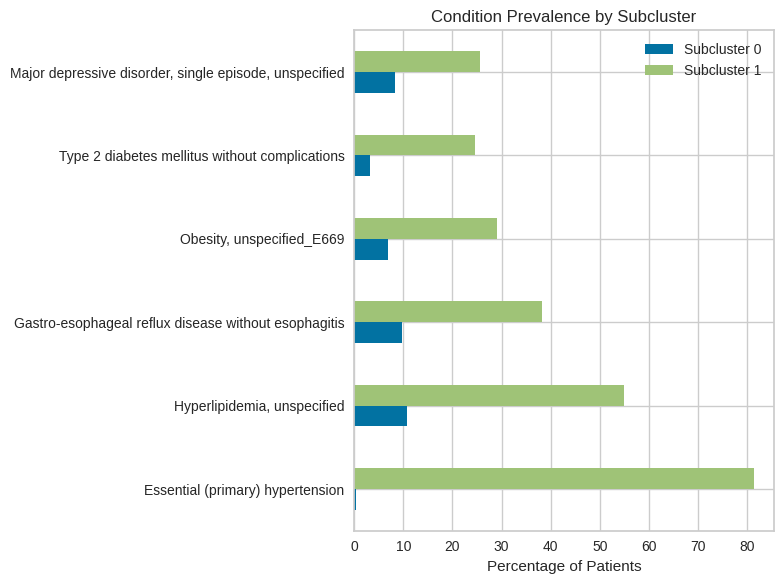

In [64]:
# choose top categorical/binary features 
top_categorical = [
    'Essential (primary) hypertension',
    'Hyperlipidemia, unspecified',
    'Gastro-esophageal reflux disease without esophagitis',
    'Obesity, unspecified_E669',
    'Type 2 diabetes mellitus without complications',
    'Major depressive disorder, single episode, unspecified']

# count % of patients with each condition in each subcluster
summary = {}
for feat in top_categorical:
    p0 = cluster_0[feat].mean()
    p1 = cluster_1[feat].mean()
    summary[feat] = {"Subcluster 0": round(p0 * 100, 1), "Subcluster 1": round(p1 * 100, 1)}

summary_df = pd.DataFrame(summary).T
summary_df.plot(kind="barh", figsize=(8, 6))
plt.title("Condition Prevalence by Subcluster")
plt.xlabel("Percentage of Patients")
plt.tight_layout()
plt.show()


## (which features are most important on fused representation -- problem area)

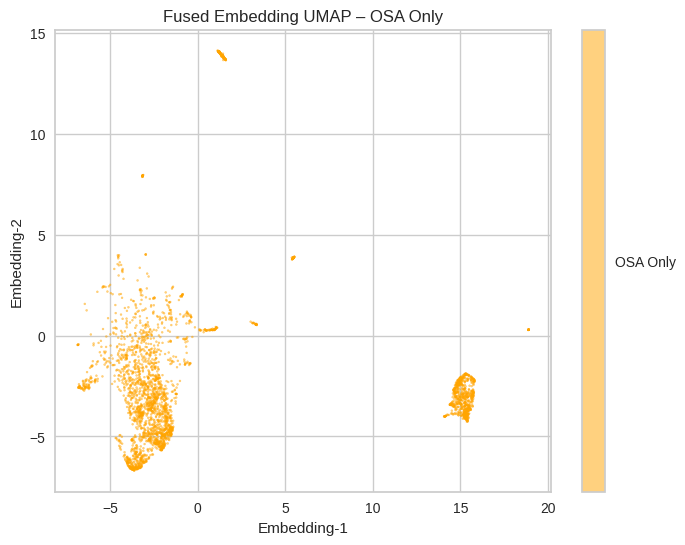

In [66]:
# test labels to OSA only
osa_mask = (y_fused_df['group'] == 0.0).values

# prev umap plot
clusterable_osa = clusterable_embedding_fused[osa_mask, :]

# get the real OSA labels (where group == 0)
labels_osa = y_fused_df.loc[osa_mask, 'group'].reset_index(drop=True)
plot_umap_embedding(clusterable_osa,labels=labels_osa,group=[0.0],colors=['orange'],point_size=2,title="Fused Embedding UMAP – OSA Only")


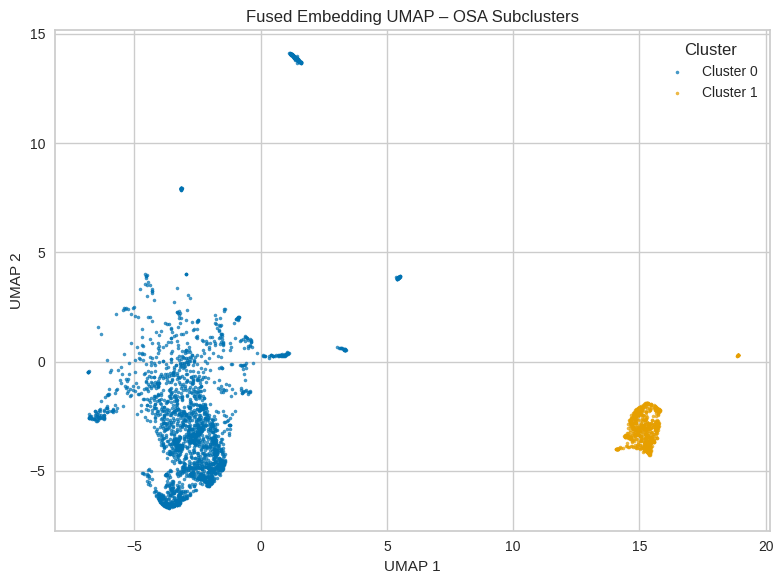

In [69]:
kmeans = KMeans(n_clusters=2, random_state=42)
osa_subclusters = kmeans.fit_predict(clusterable_osa) 
colors = ['#0072B2', '#E69F00'] 

plt.figure(figsize=(8, 6))
for cluster_id, color in zip([0, 1], colors):
    mask = (osa_subclusters == cluster_id)
    plt.scatter(
        clusterable_osa[mask, 0],
        clusterable_osa[mask, 1],
        s=5,          
        color=color,
        label=f'Cluster {cluster_id}',
        alpha=0.7)

plt.legend(title='Cluster')
plt.title("Fused Embedding UMAP – OSA Subclusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


In [70]:
fused_osa = fused_test_256[osa_mask, :]  
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(fused_osa, osa_subclusters) 

#  compute feature importances
importances = rf.feature_importances_
feature_names = [f'structured_{i}' for i in range(128)] + [f'text_{i}' for i in range(128)]

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances})

feat_imp['modality'] = feat_imp['feature'].apply(
    lambda f: 'structured' if f.startswith('structured') else 'text')

# top 50 important features
top50 = feat_imp.sort_values('importance', ascending=False).head(50)
print(top50.to_string(index=False))

       feature  importance   modality
 structured_25    0.096863 structured
structured_120    0.062736 structured
 structured_54    0.059999 structured
structured_107    0.059769 structured
structured_102    0.050763 structured
 structured_18    0.049799 structured
structured_121    0.049606 structured
structured_122    0.039909 structured
 structured_23    0.039864 structured
structured_108    0.039730 structured
 structured_15    0.039498 structured
 structured_97    0.039425 structured
 structured_52    0.039033 structured
structured_119    0.029976 structured
 structured_21    0.027111 structured
  structured_5    0.022307 structured
 structured_96    0.021478 structured
 structured_27    0.020208 structured
 structured_22    0.020041 structured
 structured_14    0.019845 structured
 structured_37    0.019130 structured
  structured_2    0.017707 structured
 structured_90    0.017281 structured
 structured_83    0.011052 structured
 structured_73    0.010923 structured
 structured_

# plotting sample features between clusters 

In [82]:
# Rebuild df_vis using previously computed results and patient metadata
df_vis = pd.DataFrame(clusterable_embedding_fused, columns=["UMAP1", "UMAP2"])
df_vis["group"] = pd.Series(y_bert_test).reset_index(drop=True)
df_vis["cluster"] = cluster_labels
df_vis["subject_id"] = group_fused_df["subject_id"].reset_index(drop=True)
df_vis["hadm_id"] = group_fused_df["hadm_id"].reset_index(drop=True)


In [73]:
mimic4_path = '/global/cfs/projectdirs/m1532/Projects_MVP/_datasets/MIMIC_IV/physionet.org/files/mimiciv/2.2/'

In [104]:
# this clusters was generated from HDBSCAN result with 7 clusters
osa_df = df_vis[df_vis["group"] == 0].copy()
top_clusters = osa_df["cluster"].value_counts().head(2).index.tolist()
print("Top 2 OSA clusters:", top_clusters)


osa_top_clusters_df = osa_df[osa_df["cluster"].isin(top_clusters)].copy()


Top 2 OSA clusters: [4, 0]


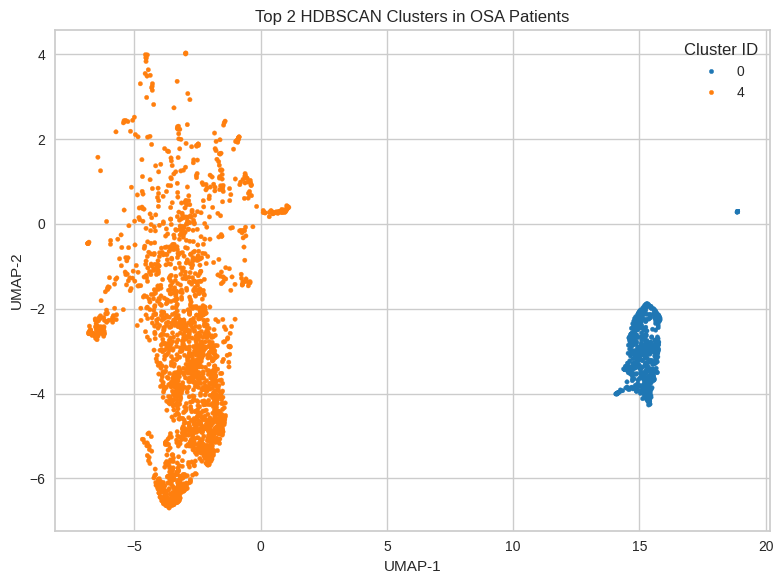

In [85]:
# plot OSA only cases from fused representation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=osa_top_clusters_df,x="UMAP1",y="UMAP2",hue="cluster",palette="tab10",s=10,edgecolor=None)

plt.title("Top 2 HDBSCAN Clusters in OSA Patients")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster ID")
plt.tight_layout()
plt.show()

In [98]:
# Load structured features
features_df = pd.read_csv(root_path_dong + 'data/osa_hf_all_features_labeled_processed.csv').drop(
    columns=['Unnamed: 0', 'text', 'osa', 'hf'], errors='ignore'
)

# Filter to only OSA patients (group == 0)
features_osa_df = features_df[features_df['group'] == 0].copy()


In [99]:
# Just in case types differ
features_osa_df['subject_id'] = features_osa_df['subject_id'].astype(str)
features_osa_df['hadm_id'] = features_osa_df['hadm_id'].astype(str)
osa_top_clusters_df['subject_id'] = osa_top_clusters_df['subject_id'].astype(str)
osa_top_clusters_df['hadm_id'] = osa_top_clusters_df['hadm_id'].astype(str)

# Merge UMAP coordinates + cluster with structured features
overlay_df = osa_top_clusters_df.merge(
    features_osa_df, on=['subject_id', 'hadm_id'], how='left'
)


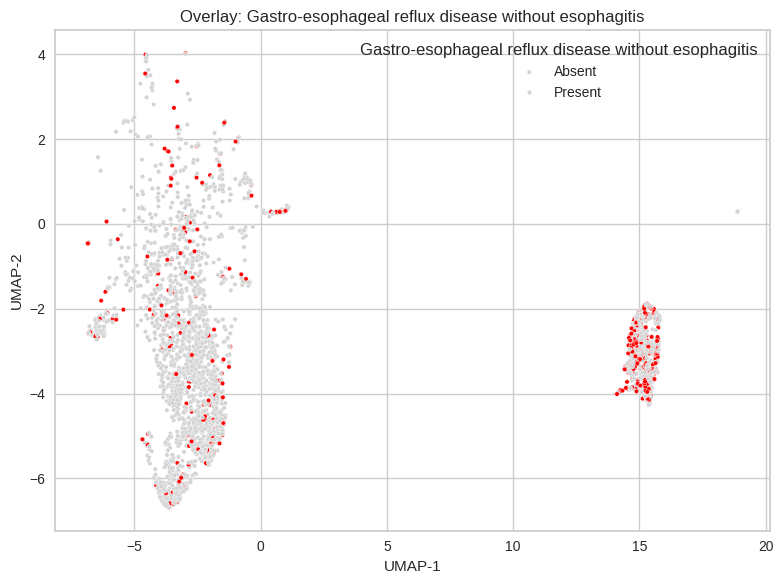

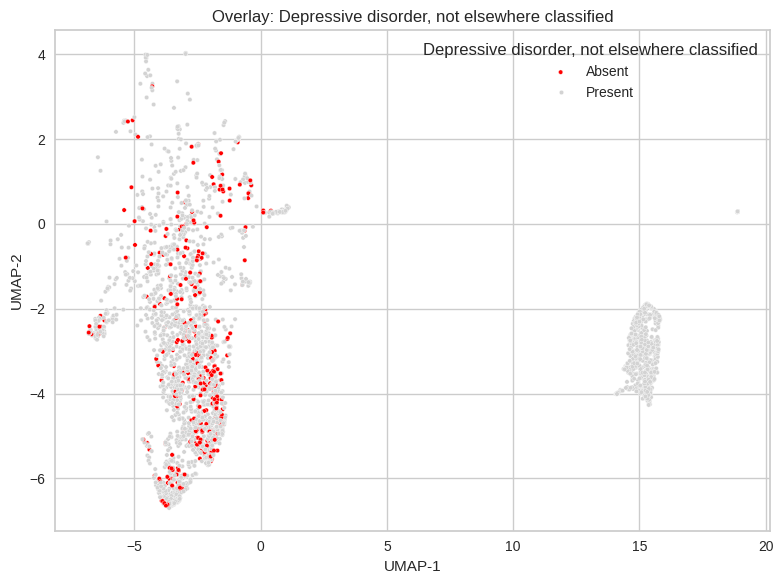

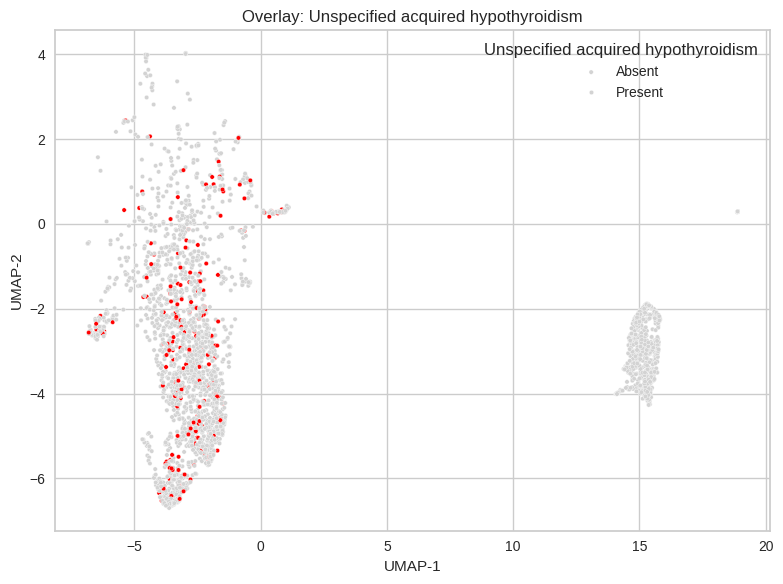

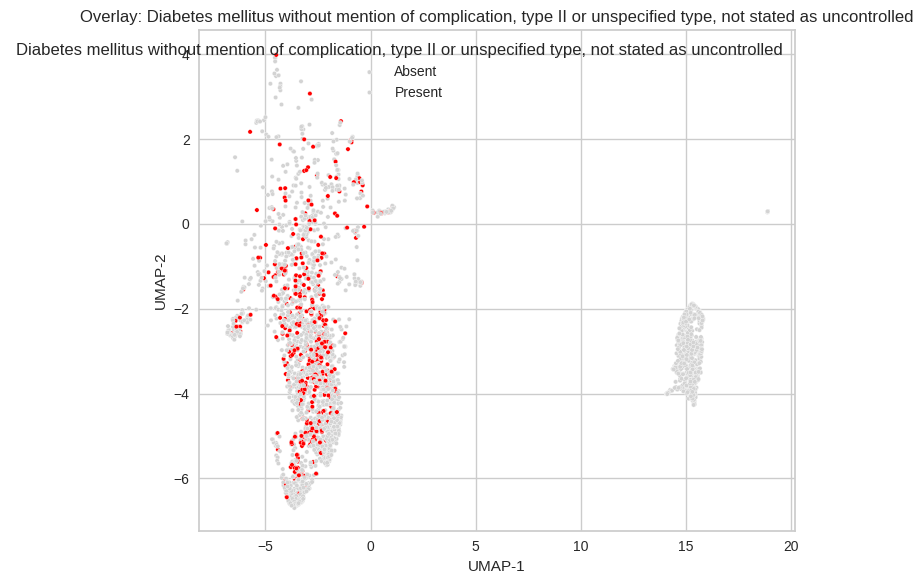

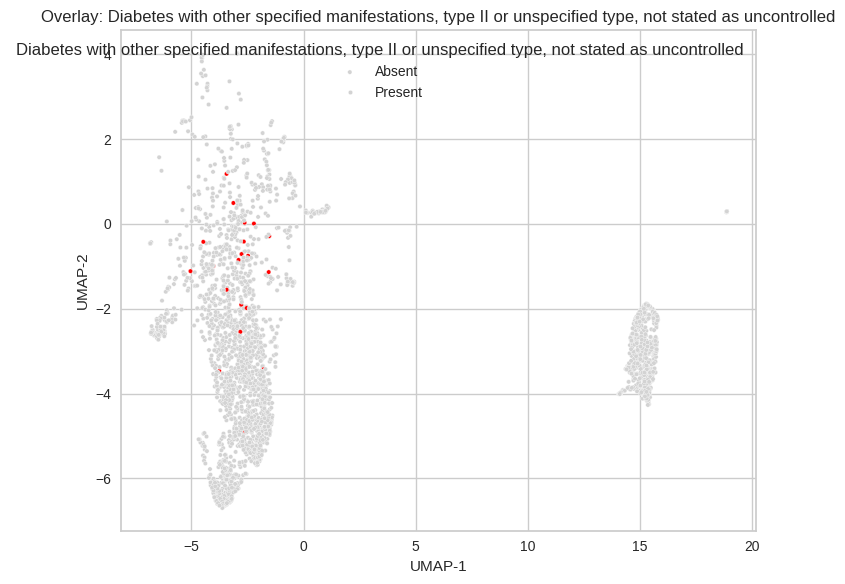

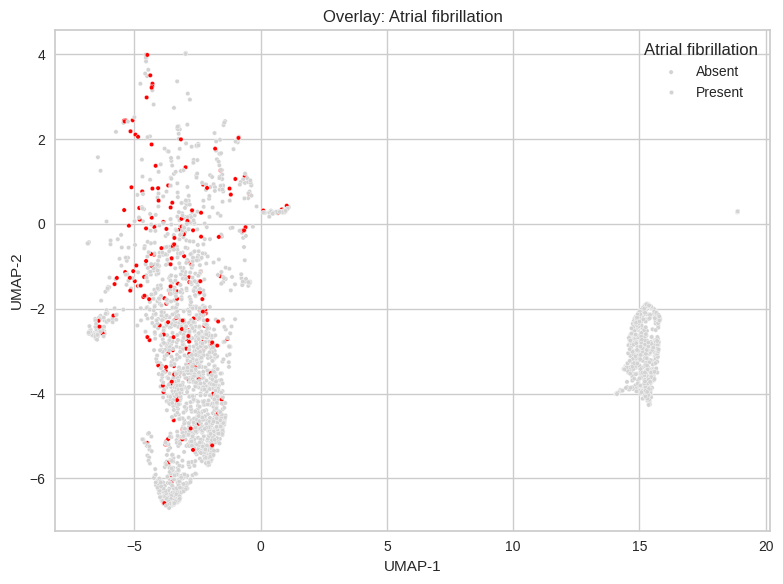

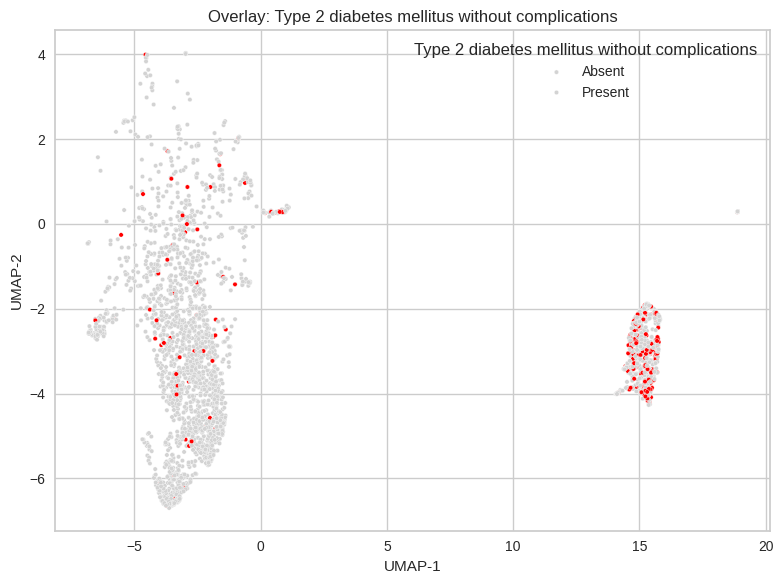

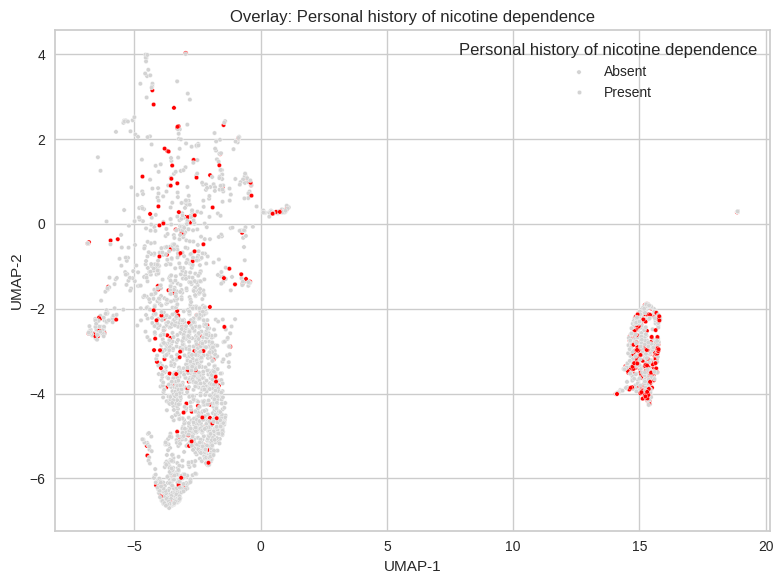

In [100]:


top_features_to_overlay = [
    "Gastro-esophageal reflux disease without esophagitis",  
    "Depressive disorder, not elsewhere classified",
    "Unspecified acquired hypothyroidism",
    "Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled",
    "Diabetes with other specified manifestations, type II or unspecified type, not stated as uncontrolled",
    "Atrial fibrillation",
    "Type 2 diabetes mellitus without complications",
    "Personal history of nicotine dependence" 
]

# Create plots
for feature in top_features_to_overlay:
    if feature not in overlay_df.columns:
        print(f"Skipping missing feature: {feature}")
        continue

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=overlay_df,
        x='UMAP1', y='UMAP2',
        hue=overlay_df[feature].fillna(0).astype(int),  # handle NaNs if any
        palette={0: 'lightgray', 1: 'red'},
        s=10
    )
    plt.title(f'Overlay: {feature}')
    plt.xlabel('UMAP-1')
    plt.ylabel('UMAP-2')
    plt.legend(title=feature, labels=['Absent', 'Present'])
    plt.tight_layout()
    plt.show()


# See movement of patients from cluster to cluster

In [113]:
osa_top_clusters_df['subject_id'] = osa_top_clusters_df['subject_id'].astype(int)
osa_top_clusters_df['hadm_id'] = osa_top_clusters_df['hadm_id'].astype(int)
admissions['subject_id'] = admissions['subject_id'].astype(int)
admissions['hadm_id'] = admissions['hadm_id'].astype(int)

In [114]:
print("\n merging admittime into OSA cluster data...")
admit_info = admissions[['subject_id', 'hadm_id', 'admittime']].drop_duplicates()
osa_top_clusters_df = pd.merge(osa_top_clusters_df,admit_info,on=['subject_id', 'hadm_id'],how='left')


 merging admittime into OSA cluster data...


In [115]:
print("\n finding patients with >5 admissions and cluster transitions")
cluster_transitions = (osa_top_clusters_df[['subject_id', 'hadm_id', 'admittime', 'cluster']].dropna().sort_values(['subject_id', 'admittime']).copy())

cluster_transitions['prev_cluster'] = cluster_transitions.groupby('subject_id')['cluster'].shift(1)
cluster_transitions['cluster_changed'] = cluster_transitions['cluster'] != cluster_transitions['prev_cluster']

admission_counts = cluster_transitions.groupby('subject_id').size()
valid_patients = admission_counts[admission_counts > 5].index

patient_changes = cluster_transitions[
    (cluster_transitions['subject_id'].isin(valid_patients)) &
    (cluster_transitions['cluster_changed'] == True)]['subject_id'].unique()


 finding patients with >5 admissions and cluster transitions


Found 88 valid patients with >5 admissions and cluster changes.

 Plotting trajectory for subject_id: 10014354


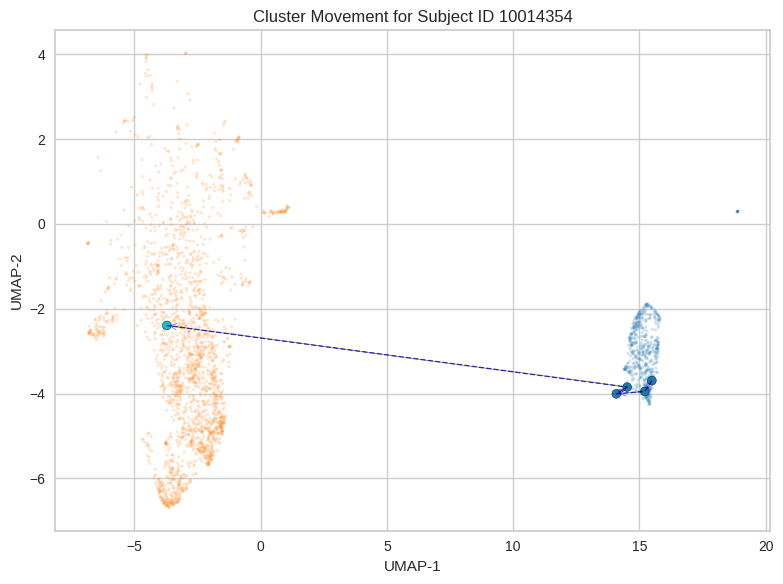


 Plotting trajectory for subject_id: 10030753


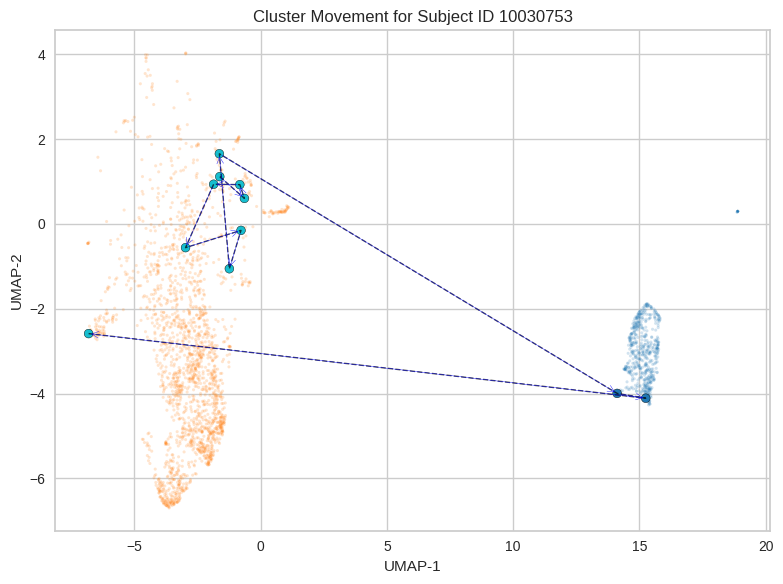


 Plotting trajectory for subject_id: 10259507


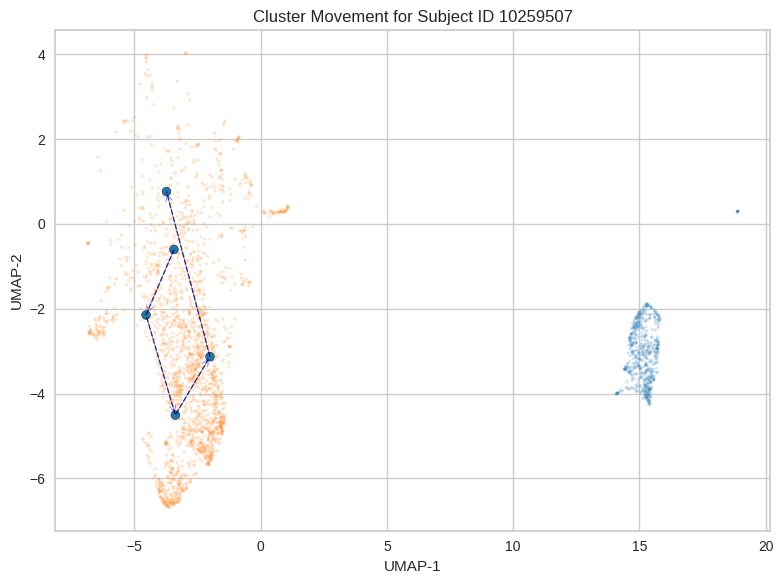


 Plotting trajectory for subject_id: 10564151


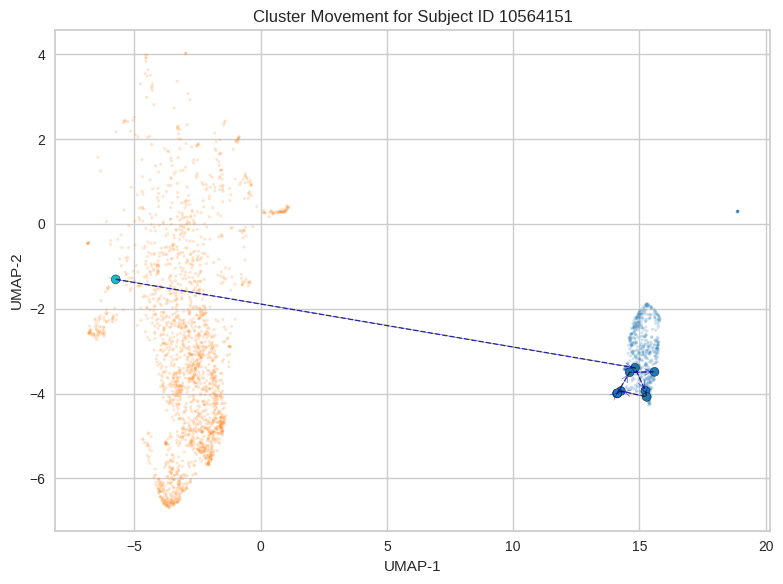


 Plotting trajectory for subject_id: 10582192


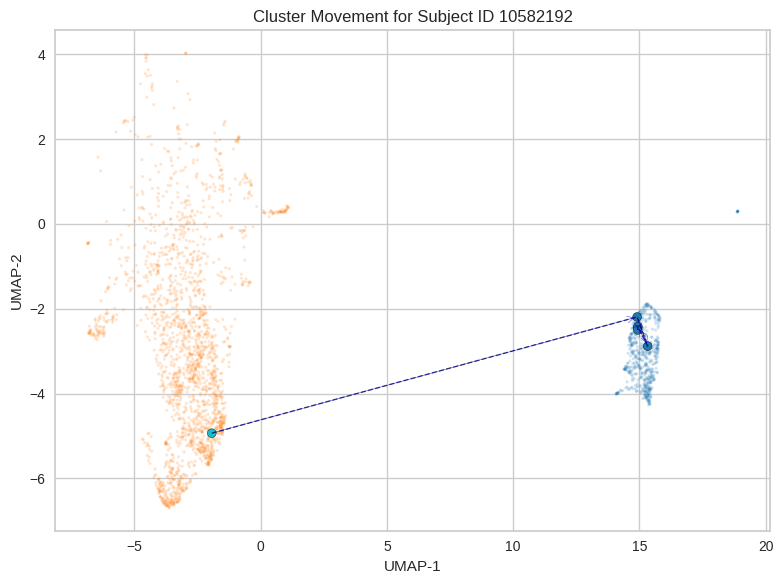

In [116]:
print(f"Found {len(patient_changes)} valid patients with >5 admissions and cluster changes.")
for patient_id in patient_changes[:5]:
    print(f"\n Plotting trajectory for subject_id: {patient_id}")
    
    patient_df = cluster_transitions[cluster_transitions['subject_id'] == patient_id].copy()
    patient_df = patient_df.sort_values('admittime')

    # merge in UMAP coordinates
    df_vis['subject_id'] = df_vis['subject_id'].astype(int)
    df_vis['hadm_id'] = df_vis['hadm_id'].astype(int)

    patient_df = patient_df.merge(df_vis[['subject_id', 'hadm_id', 'UMAP1', 'UMAP2']],on=['subject_id', 'hadm_id'],how='left').dropna()
    patient_df.rename(columns={'UMAP1': 'UMAP', 'UMAP2': 'UMAP_Y'}, inplace=True)


    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=osa_top_clusters_df, x='UMAP1', y='UMAP2',
                    hue='cluster', palette='tab10', s=5, alpha=0.2, legend=False)

    # movement path
    plt.plot(patient_df['UMAP'], patient_df['UMAP_Y'], 
             color='black', linewidth=1, linestyle='--', alpha=0.7)

    # colored dots per visit
    plt.scatter(patient_df['UMAP'], patient_df['UMAP_Y'], 
                c=patient_df['cluster'], cmap='tab10', s=40, edgecolor='black')

    # arrows
    for i in range(len(patient_df) - 1):
        x1, y1 = patient_df.iloc[i][['UMAP', 'UMAP_Y']]
        x2, y2 = patient_df.iloc[i + 1][['UMAP', 'UMAP_Y']]
        plt.annotate("", xy=(x2, y2), xytext=(x1, y1),
                     arrowprops=dict(arrowstyle="->", color='blue'))

    plt.title(f"Cluster Movement for Subject ID {patient_id}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

In [117]:
# same process except getting counts of transitiions for cohort
cluster_transitions = (osa_top_clusters_df[['subject_id', 'hadm_id', 'admittime', 'cluster']].sort_values(['subject_id', 'admittime']).copy())

cluster_transitions['prev_cluster'] = cluster_transitions.groupby('subject_id')['cluster'].shift(1)
cluster_transitions = cluster_transitions.dropna(subset=['prev_cluster'])


cluster_transitions['transition'] = (cluster_transitions['prev_cluster'].astype(int).astype(str) + ' → ' +cluster_transitions['cluster'].astype(int).astype(str))
transition_counts = cluster_transitions['transition'].value_counts().reset_index()
transition_counts.columns = ['Transition', 'Count']
print("\n Transition Frequencies:")
print(transition_counts)


 Transition Frequencies:
  Transition  Count
0      4 → 4   1273
1      0 → 0    298
2      4 → 0    198
3      0 → 4     64


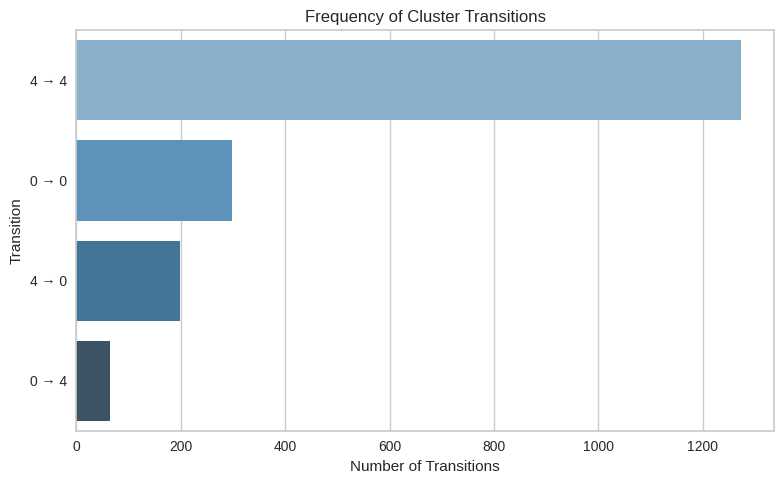

In [118]:
plt.figure(figsize=(8,5))
sns.barplot(data=transition_counts, x='Count', y='Transition', palette='Blues_d')
plt.title("Frequency of Cluster Transitions")
plt.xlabel("Number of Transitions")
plt.ylabel("Transition")
plt.tight_layout()
plt.show()

In [119]:
print("merging cluster transitions with admissions data")
transitions_with_death = cluster_transitions.merge(admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime']],on=['subject_id', 'hadm_id'],how='left')
print(f"[DEBUG] Merged DataFrame shape: {transitions_with_death.shape}")
print(f"[DEBUG] Columns after merge: {transitions_with_death.columns.tolist()}")

merging cluster transitions with admissions data
[DEBUG] Merged DataFrame shape: (1833, 9)
[DEBUG] Columns after merge: ['subject_id', 'hadm_id', 'admittime_x', 'cluster', 'prev_cluster', 'transition', 'admittime_y', 'dischtime', 'deathtime']


In [120]:
print("converting date columns to datetime")
for col in ['admittime', 'dischtime', 'deathtime']:
    if col in transitions_with_death.columns:
        transitions_with_death[col] = pd.to_datetime(transitions_with_death[col])
    else:
        print(f" col '{col}' not found in the merged df")


print(" calculating deaths after discharge")
transitions_with_death['died_after_discharge'] = (
    transitions_with_death['deathtime'].notna() & (transitions_with_death['deathtime'] > transitions_with_death['dischtime'])).astype(int)


print("death counts:")
print(transitions_with_death['died_after_discharge'].value_counts())
print("aggregating mortality per transition type")
death_stats = (transitions_with_death.groupby('transition')['died_after_discharge'].agg(['sum', 'count']).rename(columns={'sum': 'Died After', 'count': 'Total Transitions'}))
death_stats['Mortality Rate (%)'] = (death_stats['Died After'] / death_stats['Total Transitions'] * 100).round(2)

# print everything
print("\n mortality after all patient transitions:")
print(death_stats.sort_values(by='Mortality Rate (%)', ascending=False))

converting date columns to datetime
 col 'admittime' not found in the merged df
 calculating deaths after discharge
death counts:
died_after_discharge
0    1832
1       1
Name: count, dtype: int64
aggregating mortality per transition type

 mortality after all patient transitions:
            Died After  Total Transitions  Mortality Rate (%)
transition                                                   
0 → 0                1                298                0.34
0 → 4                0                 64                0.00
4 → 0                0                198                0.00
4 → 4                0               1273                0.00


# Markov state transition between clusters

In [179]:
cluster_transitions_sorted['next_cluster'] = cluster_transitions_sorted.groupby('subject_id')['cluster'].shift(-1)
valid_transitions = cluster_transitions_sorted.dropna(subset=['next_cluster']).copy()

valid_transitions['transition'] = (valid_transitions['cluster'].astype(int).astype(str) + ' → ' +valid_transitions['next_cluster'].astype(int).astype(str))

In [180]:
transition_counts = valid_transitions.groupby(['cluster', 'next_cluster']).size().unstack(fill_value=0)
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0).round(3)

print("\n markov transition matrix")
print(transition_probs)


 markov transition matrix
next_cluster    0.0    4.0
cluster                   
0             0.826  0.174
4             0.129  0.871
